In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore') 
import matplotlib as mpl
mpl.rc('image', cmap='RdBu_r')

In [2]:
import yaml
import math
import random
import copy

import glob
import sklearn
import seaborn
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import dill as pkl
import itertools as it
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from data.dataset import MultiTaskDataset, MultiTaskDataModule
from model.transformer import MultitaskModelModule
import misc.utils as utils
from scripts.main import setup_dataset, setup_model, setup_trainer

import wandb
import torch
import torch.nn.functional as F
from einops import rearrange, repeat

In [3]:
api = wandb.Api(timeout=29)
PROJECT = 'effie-li/multitask-transformer-v1'
LOCAL_RUN_ROOT = '/data5/liyuxuan/multitask/multitask-transformer-v1/'
runs, config_list, id_list = utils.fetch_runs(api, PROJECT)

In [4]:
target_runs = {'D2H11':['2ldn6lf7','3f2hx0xr','3evkwn0z','3azworia'],
               'D2H22':['gwqgv4db','1z3g43d1','21q8uhnx','s1xjxnyo'],
               'D2H33':['2or2dcpr','1vwiq3pl','bai713cn','2d59t3kc'],
               'D2H44':['11tjh2t4','bln3rf2e','3iec955a','39mjbdgn'],
               'D2H66':['173w6fac','3q52c0zq','1gepj3q3','1hgg0cd1'],

               'D2H12':['2uuui276','22metkkq','29gaef6f','2isbe7f3'],
               'D2H13':['31hpgy03','2nurpz5k','3l5q3via','2uhy2yj8'],
               'D2H14':['3cyk4n4w','ki21vp2h','3bwhno0u','35xuro1q'],
               'D2H16':['2wfk0wr3','1iirnajx','25xhs6v2','1bm6gsc6'],

               'D2H21':['3twhj2p5','3fjb83rc','26bnjc2f','2esi47j2'],
               'D2H31':['hcl69r4n','1u551rj3','2aszyemw','1032wquv'],
               'D2H41':['uguetv2y','1qt7kyot','gfyq8h40','2ywypjdg'],
               'D2H61':['3gj2leca','7u0895vb','1raqacfe','37xa5568'],
              }

not_finished = []

In [5]:
config = yaml.safe_load(open('../config/v1_3f_mt.yaml'))
dataset = MultiTaskDataset(config)
datamodule = MultiTaskDataModule(dataset=dataset, 
                                    dataset_frac=config['dataset']['dataset_frac'],
                                    batch_size=config['dataset']['batch_size'], 
                                    split_params=config['dataset']['split_params'])

learning curves

In [ ]:
dfs = []
for arch in target_runs.keys():
    for runid in target_runs[arch]:
        lc = utils.get_learning_curve_data(api=api, project=PROJECT, runid=runid,
                                           keys=['epoch','trainer/global_step','val/item_acc','val/label_acc'])
        lc['phase'] = ['val'] * len(lc)
        lc['arch'] = [arch] * len(lc)
        lc['runid'] = [runid] * len(lc)
        dfs.append(lc)
df_lc = pd.concat(dfs)
# pkl.dump(df_lc, open('temp_pkl_files/multi_task_df_lc.pkl','wb'))

In [ ]:
# pkl.dump(df_lc, open('temp_pkl_files/multi_task_df_lc.pkl','wb'))

max val performance

In [5]:
max_val_acc_df = pd.read_csv('temp_pkl_files/max_val_acc.pkl')

In [ ]:
dfs = []
keys = ['epoch','trainer/global_step',
        'val/item_acc', 'val/label_acc',
        'val/task0_item_acc', 'val/task0_label_acc',
        'val/task1_item_acc', 'val/task1_label_acc',
        'val/task2_item_acc', 'val/task2_label_acc',
        'val/task3_item_acc', 'val/task3_label_acc',
        'val/task4_item_acc', 'val/task4_label_acc',
        'val/task5_item_acc', 'val/task5_label_acc']
for arch in target_runs.keys():
    for runid in target_runs[arch]:
        if runid in not_finished: continue
        if runid in max_val_acc_df['runid'].values: continue

        lc = utils.get_learning_curve_data(api=api, project=PROJECT, runid=runid, keys=keys)
        lc = lc[lc['trainer/global_step']<=38000]
        max_row = lc[lc['val/label_acc']==lc['val/label_acc'].max()]
        max_row['runid'] = runid
        max_row['embed_dim'] = config_list[id_list.index(runid)]['model']['embed_dim']
        max_row['n_head_l0'] = config_list[id_list.index(runid)]['model']['n_heads'][0]
        max_row['n_head_l1'] = config_list[id_list.index(runid)]['model']['n_heads'][1]
        dfs.append(max_row)
df = pd.concat(dfs)
max_val_acc_df = pd.concat([max_val_acc_df, df])
# max_val_acc_df.to_csv('temp_pkl_files/max_val_acc.pkl')

In [ ]:
x = max_val_acc_df[max_val_acc_df['n_head_l0']==max_val_acc_df['n_head_l1']].groupby(['n_head_l0','n_head_l1'])
x[['val/task5_item_acc','val/task5_label_acc']].agg([np.mean, np.std]).round(4)*100

val/task5_item_acc       val/task5_label_acc       
                                  mean   std                mean    std
n_head_l0 n_head_l1                                                    
1         1                      86.77  8.63               73.57  10.59
2         2                      97.20  0.95               92.73   2.05
3         3                      98.37  0.33               95.23   0.90
4         4                      99.08  0.70               97.53   1.71
6         6                      99.62  0.13               98.65   0.54

In [ ]:
x = max_val_acc_df[max_val_acc_df['n_head_l0']>max_val_acc_df['n_head_l1']].groupby(['n_head_l0','n_head_l1'])
x[['val/task5_item_acc','val/task5_label_acc']].agg([np.mean, np.std]).round(4)*100

val/task5_item_acc        val/task5_label_acc       
                                  mean    std                mean    std
n_head_l0 n_head_l1                                                     
2         1                      80.03  11.15               64.28  12.87
3         1                      78.22  12.21               61.27  18.82
4         1                      82.46  16.50               71.27  24.19
6         1                      97.95   0.29               94.08   0.82

In [ ]:
x = max_val_acc_df[max_val_acc_df['n_head_l0']<max_val_acc_df['n_head_l1']].groupby(['n_head_l0','n_head_l1'])
x[['val/task5_item_acc','val/task5_label_acc']].agg([np.mean, np.std]).round(4)*100

val/task5_item_acc       val/task5_label_acc      
                                  mean   std                mean   std
n_head_l0 n_head_l1                                                   
1         2                      95.72  0.54               90.74  0.66
          3                      98.70  0.71               93.76  2.15
          4                      99.64  0.28               98.36  1.05
          6                      99.63  0.29               98.54  1.10

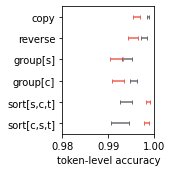

In [35]:
# generalization accuracy by task

fig, ax = plt.subplots(1, figsize=[2.5,2.5])
df = max_val_acc_df[np.in1d(max_val_acc_df['runid'], max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values)]

task_idx = {'copy':0,'reverse':1,'group[s]':2,'group[c]':4,'sort[s,c,t]':3,'sort[c,s,t]':5}
a = 0.25
for i, task in enumerate(task_idx.keys()):
    values = df['val/task%d_item_acc'%task_idx[task]].values.tolist()
    ax.bar(np.mean(values), [i], xerr=sp.stats.sem(values), capsize=2, ecolor='#EE6055', color='w')

    values = df['val/task%d_label_acc'%task_idx[task]].values.tolist()
    ax.bar(np.mean(values), [i], xerr=sp.stats.sem(values), capsize=2, ecolor='#6B6D76', color='w')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#EE6055', lw=2),
                Line2D([0], [0], color='#6B6D76', lw=2)]
# ax.legend(custom_lines, ['item', 'label'], loc='upper left', handlelength=1.5, handletextpad=0.4) #, columnspacing=1.2)
ax.set_yticks(range(6))
ax.set_yticklabels(task_idx.keys())
ax.set_xlim([0.98, 1])
ax.set_ylim([-0.5,5.5])
ax.set_xlabel('token-level accuracy')

plt.gca().invert_yaxis()
fig.tight_layout()
# fig.savefig('../figure/v1/six_task_acc_by_task.pdf')

time took for mastery in item/label prediction

In [ ]:
max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values

array(['35xuro1q', '2wfk0wr3', '3iec955a', '1hgg0cd1', '3cyk4n4w'],
      dtype=object)

In [ ]:
max_val_acc_df.sort_values('val/item_acc').tail(5)['runid'].values

array(['1hgg0cd1', '2wfk0wr3', '35xuro1q', '3iec955a', '3cyk4n4w'],
      dtype=object)

In [27]:
max_step = 38000
val_lc = {}
for runid in max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values:
    keys = ['epoch','trainer/global_step']+['val/task%d_item_acc'%t for t in range(6)]+['val/task%d_label_acc'%t for t in range(6)]
    lc = utils.get_learning_curve_data(api=api, project=PROJECT, runid=runid, keys=keys)
    val_lc[runid] = lc[lc['trainer/global_step']<=max_step]

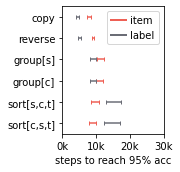

In [33]:
fig, ax = plt.subplots(1, figsize=[2.6,2.5])
threshold = 0.95

task_idx = {'copy':0,'reverse':1,'group[s]':2,'group[c]':4,'sort[s,c,t]':3,'sort[c,s,t]':5}
a = 0.25
for i, task in enumerate(task_idx.keys()):
    steps = []
    for runid in val_lc:
        x = val_lc[runid][['trainer/global_step', 'val/task%d_item_acc'%task_idx[task]]]
        steps.append(x['trainer/global_step'][x['val/task%d_item_acc'%task_idx[task]]>=threshold].values[0])
    ax.bar(np.mean(steps), [i], xerr=sp.stats.sem(steps), capsize=2, ecolor='#EE6055')

    steps = []
    for runid in val_lc:
        x = val_lc[runid][['trainer/global_step', 'val/task%d_label_acc'%task_idx[task]]]
        steps.append(x['trainer/global_step'][x['val/task%d_label_acc'%task_idx[task]]>=threshold].values[0])
    ax.bar(np.mean(steps), [i], xerr=sp.stats.sem(steps), capsize=2, ecolor='#6B6D76')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#EE6055', lw=2),
                Line2D([0], [0], color='#6B6D76', lw=2)]
ax.legend(custom_lines, ['item', 'label'], loc='upper right', handlelength=1.5, handletextpad=0.4)
ax.set_yticks(range(6))
ax.set_yticklabels(task_idx.keys())
ax.set_xlim([3000, 30000])
ax.set_ylim([-0.5,5.5])
ax.set_xticks([0, 10000,20000,30000])
ax.set_xticklabels(['0k', '10k','20k','30k'])
ax.set_xlabel('steps to reach 95% acc')

plt.gca().invert_yaxis()
fig.tight_layout()
# fig.savefig('../figure/v1/six_task_95acc_step.pdf')

top1 acc

In [ ]:
runid = '2h571r65'
device = 'cuda:7'
model, datamodule = utils.reconstruct_model_and_dm(local_run_root=LOCAL_RUN_ROOT, 
                                                    runid=runid, 
                                                    config=config_list[id_list.index(runid)],
                                                    train_idx=runs[runs['id']==runid]['data.train_idx'].values[0],
                                                    val_idx=runs[runs['id']==runid]['data.val_idx'].values[0],
                                                    batch_size=config_list[id_list.index(runid)]['model']['n_task']*200)
_ = model.to(device)
for batch in datamodule.val_dataloader(): break
batch = utils.batch_to_device(batch, device, except_keys=['task'])
batch = model.process_batch(batch, teacher_forcing=False)

In [ ]:
def get_rollout_acc(model):
    with torch.no_grad():
        item_pred, label_pred = model.forward_rollout(batch['src'])
        result_dict =  {'pred': {'item': item_pred, 
                                'label': label_pred},
                        'target': {'item': batch['target']['item'], 
                                'label': batch['target']['label']}}
    _, ro_acc = model._calc_loss_acc(result_dict)
    ro_acc = {k:ro_acc[k].cpu().numpy() for k in ro_acc.keys()}
    return ro_acc

In [ ]:
for arch in target_runs.keys():
    for runid in target_runs[arch]:
        if runid in not_finished: continue

        fname = 'temp_pkl_files/%s_max_val_ckpt_roacc.pkl'%runid
        if os.path.isfile(fname): continue

        epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
        step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
        ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
        model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
        ro_acc = get_rollout_acc(model)
        df = pd.DataFrame.from_dict({k:[ro_acc[k]] for k in ro_acc}) # each acc has one scalar and pandas complains so turning the values into list of one float
        df['runid'] = runid
        df['arch'] = arch
        # df.to_csv(fname)

In [46]:
dfs = []
for runid in sum(target_runs.values(),[]):
    fname = 'temp_pkl_files/%s_max_val_ckpt_roacc.pkl'%runid
    if not os.path.isfile(fname): continue

    df = pd.read_csv(fname)
    heads = config_list[id_list.index(runid)]['model']['n_heads']
    df['arch'] = 'D2H%d%d'%(heads[0], heads[1])
    df['n_head_l0'] = heads[0]
    df['n_head_l1'] = heads[1]
    dfs.append(df)
df_roacc = pd.concat(dfs)

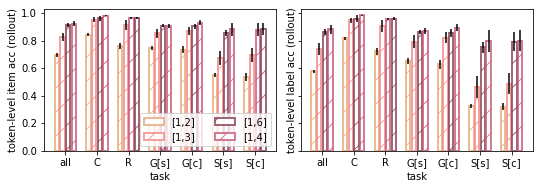

In [ ]:
arch_type = 'backload' # 'balanced' or 'frontload' or 'backload'

if arch_type=='balanced':
    df_plot = df_roacc[(df_roacc['n_head_l0'])==(df_roacc['n_head_l1'])]
    figsize = [8,2.7]
elif arch_type=='frontload':
    df_plot = df_roacc[(df_roacc['n_head_l0'])>(df_roacc['n_head_l1'])]
    figsize = [7.6,2.7]
else: # 'backload'
    df_plot = df_roacc[(df_roacc['n_head_l0'])<(df_roacc['n_head_l1'])]
    figsize = [7.6,2.7]

fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

colors = {'D2H11':'#e3d7d1',
          'D2H22':'#E7AB79','D2H12':'#E7AB79','D2H21':'#E7AB79',
          'D2H33':'#F68989','D2H13':'#F68989','D2H31':'#F68989',
          'D2H44':'#C65D7B','D2H14':'#C65D7B','D2H41':'#C65D7B',
          'D2H66':'#874356','D2H16':'#874356','D2H61':'#874356'
          }

n_arch = len(df_plot['arch'].unique())
df_plot = df_plot.groupby('arch').agg([np.mean, sp.stats.sem])
w = 0.18
x_jitter = np.linspace(-w*n_arch/2+w/2, w*n_arch/2-w/2, n_arch)

for i, metric in enumerate(['item','label']):
    ax = axes[i]
    for x, t in enumerate(['all',0,1,2,4,3,5]):
        if t=='all': acc_col = '%s_acc'%metric
        else: acc_col = 'task%d_%s_acc'%(t,metric)
        accs = df_plot[acc_col, 'mean']
        for a, arch in enumerate(accs.sort_values().index):
            head0, head1 = int(arch[-2]), int(arch[-1])
            ax.bar(x+x_jitter[a], accs[arch], yerr=df_plot[acc_col,'sem'][arch], lw=2, width=w*0.75, alpha=0.8, 
                   color=colors[arch] if head0==head1 else 'white', 
                   edgecolor=colors[arch],
                   hatch='/' if head0<head1 else '',
                   label='[%d,%d]'%(head0, head1) if t=='all' else None)

    if i==0: ax.legend(ncol=2, loc='lower right')
    ax.set_ylabel('token-level %s acc (rollout)' % (metric))
    ax.set_xticks(np.arange(7))
    _ = ax.set_xticklabels(['all','C','R','G[s]','G[c]','S[s]','S[c]'])
    ax.set_xlabel('task')

axes[0].set_ylim([0,1.03])
fig.tight_layout()
# fig.savefig('../figure/v1/six_task_rollout_acc_%s.pdf'%arch_type)

In [48]:
arch_type = []
for i in range(len(df_roacc)):
    n0 = df_roacc['n_head_l0'].values[i]
    n1 = df_roacc['n_head_l1'].values[i]
    if n0 == n1: arch_type.append('balanced')
    elif n0 > n1: arch_type.append('frontload')
    else: arch_type.append('backload')
df_roacc['arch_type'] = arch_type

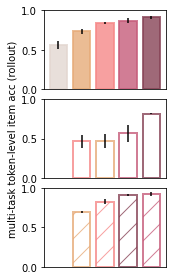

In [66]:
fig, axes = plt.subplots(3, 1, figsize=[2.5,4], sharey=True, sharex=True)

colors = {'D2H11':'#e3d7d1',
          'D2H22':'#E7AB79','D2H12':'#E7AB79','D2H21':'#E7AB79',
          'D2H33':'#F68989','D2H13':'#F68989','D2H31':'#F68989',
          'D2H44':'#C65D7B','D2H14':'#C65D7B','D2H41':'#C65D7B',
          'D2H66':'#874356','D2H16':'#874356','D2H61':'#874356'
          }

w = 0.2
n_arch = 5
x_jitter = np.linspace(-w*n_arch/2+w/2, w*n_arch/2-w/2, n_arch)
for x, arch_type in enumerate(['balanced', 'frontload', 'backload']):
    df_plot = df_roacc[df_roacc['arch_type'] == arch_type]
    df_plot = df_plot.groupby('arch').agg([np.mean, sp.stats.sem])

    accs = df_plot['item_acc', 'mean']
    for a, arch in enumerate(accs.sort_values().index):
        head0, head1 = int(arch[-2]), int(arch[-1])
        axes[x].bar(x_jitter[a] if x==0 else x_jitter[a+1], accs[arch], yerr=df_plot['item_acc','sem'][arch], lw=2, width=w*0.75, alpha=0.8, 
            color=colors[arch] if head0==head1 else 'white', 
            edgecolor=colors[arch],
            hatch='/' if head0<head1 else '',
            label='[%d,%d]'%(head0, head1))
    axes[x].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# ax.legend(ncol=3, loc='lower right', prop={'size': 8})
axes[1].set_ylabel('multi-task token-level item acc (rollout)')
# axes[1].set_xticks(np.arange(3))
# _ = ax.set_xticklabels(['in both layers','1st layer only','2nd layer only'])
# axes[-1].set_xlabel('multi-headed attention')
axes[0].set_ylim([0,1])

fig.tight_layout(h_pad=0)
# fig.savefig('../figure/v1/six_task_perf.pdf')

length generalization performance

In [ ]:
config = yaml.safe_load(open('../config/v1_3f_mt.yaml'))
config['dataset']['fname'] = '/data5/liyuxuan/multitask/dataset/v1/shape5-color5-texture5-task8-N10000-5-25.pkl'
config['dataset']['batch_size'] = config_list[id_list.index('3cyk4n4w')]['model']['n_task']*1000
datamodule2 = setup_dataset(config)

In [ ]:
runid = '3cyk4n4w'
device = 'cuda:5'
model, datamodule = utils.reconstruct_model_and_dm(local_run_root=LOCAL_RUN_ROOT, 
                                                    runid=runid, 
                                                    config=config_list[id_list.index(runid)],
                                                    train_idx=runs[runs['id']==runid]['data.train_idx'].values[0],
                                                    val_idx=runs[runs['id']==runid]['data.val_idx'].values[0],
                                                    batch_size=config_list[id_list.index(runid)]['model']['n_task']*1000) #1000
_ = model.to(device)

In [ ]:
for batch_train in datamodule2.train_dataloader(): break
batch_train = utils.batch_to_device(batch_train, device, except_keys=['task'])
batch_train = model.process_batch(batch_train, teacher_forcing=False)
seq_lens_train = model._calc_batch_seq_len(batch_train['src']['item'], teacher_forcing=False)
seq_lens_train = np.array([x.cpu() for x in seq_lens_train])

for batch_val in datamodule.val_dataloader(): break
batch_val = utils.batch_to_device(batch_val, device, except_keys=['task'])
batch_val = model.process_batch(batch_val, teacher_forcing=False)
seq_lens_val = model._calc_batch_seq_len(batch_val['src']['item'], teacher_forcing=False)
seq_lens_val = np.array([x.cpu() for x in seq_lens_val])

In [ ]:
x = {'batch_train': batch_train, 'seq_lens_train': seq_lens_train, 'batch_val':batch_val,'seq_lens_val':seq_lens_val}
pkl.dump(x, open('temp_pkl_files/ro_train_val_batches_1k.pkl','wb'))

In [ ]:
for runid in max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values:
    epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
    step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
    ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
    model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)

    print('rolling out model %s ...'%runid)
    
    with torch.no_grad():
        item_pred, label_pred = model.forward_rollout(batch_train['src'])
    pkl.dump({'item_pred':item_pred, 'label_pred':label_pred}, open('temp_pkl_files/ro_train_batch_pred_%s.pkl'%runid,'wb'))
    del item_pred, label_pred

    with torch.no_grad():
        item_pred, label_pred = model.forward_rollout(batch_val['src'])
    pkl.dump({'item_pred':item_pred, 'label_pred':label_pred}, open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'wb'))
    del item_pred, label_pred

rolling out model 35xuro1q ...
rolling out model 2wfk0wr3 ...
rolling out model 3iec955a ...
rolling out model 1hgg0cd1 ...
rolling out model 3cyk4n4w ...


In [ ]:
def get_tf_len_acc(model, runid, teacher_forcing=True):
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_train['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_train_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    len_acc_dfs = []
    for l in np.unique(seq_lens_train):
        seq_ind = np.where(seq_lens_train==l)[0]
        result_dict =  {'pred': {'item': item_pred[seq_ind], 
                                 'label': label_pred[seq_ind]},
                        'target': {'item': batch_train['target']['item'][seq_ind], 
                                   'label': batch_train['target']['label'][seq_ind]}}
        _, tf_acc = model._calc_loss_acc(result_dict)
        tf_acc = {k:tf_acc[k].cpu().numpy() for k in tf_acc.keys()}
        df = pd.DataFrame.from_dict({k:[tf_acc[k]] for k in tf_acc})
        len_acc_dfs.append(df)
    df_train = pd.concat(len_acc_dfs)
    df_train['seq_len'] = np.unique(seq_lens_train)
    df_train['phase'] = 'train'

    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_val['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    len_acc_dfs = []
    for l in np.unique(seq_lens_val):
        seq_ind = np.where(seq_lens_val==l)[0]
        result_dict =  {'pred': {'item': item_pred[seq_ind], 
                                'label': label_pred[seq_ind]},
                        'target': {'item': batch_val['target']['item'][seq_ind], 
                                   'label': batch_val['target']['label'][seq_ind]}}
        _, tf_acc = model._calc_loss_acc(result_dict)
        tf_acc = {k:tf_acc[k].cpu().numpy() for k in tf_acc.keys()}
        df = pd.DataFrame.from_dict({k:[tf_acc[k]] for k in tf_acc})
        len_acc_dfs.append(df)
    df_val = pd.concat(len_acc_dfs)
    df_val['seq_len'] = np.unique(seq_lens_val)
    df_val['phase'] = 'val'
    return pd.concat([df_train, df_val])

In [ ]:
max_val_acc_df.sort_values('val/label_acc').tail(5)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,epoch,trainer/global_step,val/item_acc,val/label_acc,val/task0_item_acc,val/task0_label_acc,...,val/task3_item_acc,val/task3_label_acc,val/task4_item_acc,val/task4_label_acc,val/task5_item_acc,val/task5_label_acc,runid,embed_dim,n_head_l0,n_head_l1
29,29,29.0,165.0,NaN,16,35539,0.994624,0.993003,0.996970,0.998518,...,0.998571,0.991156,0.989718,0.993464,0.996655,0.985617,35xuro1q,192,1,4
18,18,18.0,18.0,151.0,15,32542,0.994533,0.994422,0.993658,0.998191,...,0.997050,0.990642,0.991602,0.995410,0.999171,0.992575,2wfk0wr3,192,1,6
8,8,8.0,8.0,150.0,15,32328,0.995760,0.995660,0.997808,0.998953,...,0.998891,0.993569,0.993436,0.996168,0.998417,0.993698,3iec955a,192,4,4
27,27,27.0,172.0,NaN,17,37038,0.994263,0.996011,0.995084,0.998084,...,0.998862,0.996841,0.989432,0.994370,0.997634,0.993573,1hgg0cd1,192,6,6
16,16,16.0,16.0,160.0,16,34469,0.997591,0.997613,0.996647,0.999016,...,0.999507,0.996503,0.996377,0.997659,0.999580,0.997297,3cyk4n4w,192,1,4


In [ ]:
dfs = []
runids = max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values
for i, runid in enumerate(runids):
    epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
    step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
    ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
    model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
    
    df = get_tf_len_acc(model, runid, teacher_forcing=False)
    df['runid'] = runid
    dfs.append(df)
# token_lvl_acc_df = pd.concat(dfs)
# pkl.dump(token_lvl_acc_df, open('temp_pkl_files/six_task_acc_by_len_token_lvl.pkl','wb'))

token_lvl_roacc_df = pd.concat(dfs)
# pkl.dump(token_lvl_roacc_df, open('temp_pkl_files/six_task_roacc_by_len_token_lvl.pkl','wb'))

In [68]:
token_lvl_acc_df = pkl.load(open('temp_pkl_files/six_task_acc_by_len_token_lvl.pkl','rb'))

In [94]:
df_plot['seq_len'].values

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52])

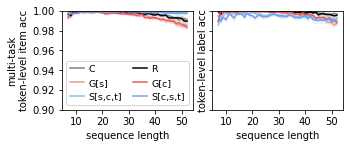

In [125]:
fig, axes = plt.subplots(1, 2, figsize=[4.8,2], sharey=True, sharex=True)

alpha = 0.8
task_display_name = {'C':0,'G[s]':2,'S[s,c,t]':3,'R':1,'G[c]':4,'S[c,s,t]':5} # display name to task index
colors = {'C':'grey','R':'black','G[s]':'#ed9898','G[c]':'#ed5858','S[s,c,t]':'#79c9ed','S[c,s,t]':'#799aed'}
w = 0.25
df_plot = token_lvl_acc_df.groupby(['seq_len']).agg([np.mean, sp.stats.sem]).reset_index()

for i, (task_name, task_ind) in enumerate(task_display_name.items()):
    axes[0].plot(df_plot['seq_len'].values, df_plot['task%d_item_acc'%task_ind,'mean'].values, color=colors[task_name], label=task_name)
    axes[0].fill_between(df_plot['seq_len'].values, 
                         df_plot['task%d_item_acc'%task_ind,'mean'].values+df_plot['task%d_item_acc'%task_ind,'sem'].values, 
                         df_plot['task%d_item_acc'%task_ind,'mean'].values-df_plot['task%d_item_acc'%task_ind,'sem'].values, 
                         color=colors[task_name], alpha=0.1)

for i, (task_name, task_ind) in enumerate(task_display_name.items()):
    axes[1].plot(df_plot['seq_len'].values, df_plot['task%d_label_acc'%task_ind,'mean'].values, color=colors[task_name], label=task_name)
    axes[1].fill_between(df_plot['seq_len'].values, 
                         df_plot['task%d_label_acc'%task_ind,'mean'].values+df_plot['task%d_label_acc'%task_ind,'sem'].values, 
                         df_plot['task%d_label_acc'%task_ind,'mean'].values-df_plot['task%d_label_acc'%task_ind,'sem'].values, 
                         color=colors[task_name], alpha=0.1)

axes[0].legend(ncol=2, loc='lower center', prop={'size':9.5}, handlelength=1.5, handletextpad=0.4, columnspacing=1.2)
axes[0].set_ylim(0.9,1)
axes[0].set_yticks([0.90,0.92,0.94,0.96,0.98,1.00])
axes[0].set_ylabel('multi-task\ntoken-level item acc')
axes[1].set_ylabel('token-level label acc')
axes[0].set_xlabel('sequence length')
axes[1].set_xlabel('sequence length')
axes[0].set_xticks(range(10,51)[::10])

fig.tight_layout(pad=0.5)
# fig.savefig('../figure/v1/six_task_acc_by_len_top5.pdf')
# fig.savefig('../figure/v1/six_task_roacc_by_len_top5.pdf')

length generalization - sequence-level accuracy

In [ ]:
def get_tf_len_acc_seq_lvl(model, runid, teacher_forcing=True):
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_train['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_train_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    
    len_acc_dfs = []
    for l in np.unique(seq_lens_train):
        seq_ind = np.where(seq_lens_train==l)[0]
        len_accs = {k:[] for k in ['task_acc','item_acc','label_acc'] + ['task%d_task_acc'%i for i in range(6)] + ['task%d_item_acc'%i for i in range(6)] + ['task%d_label_acc'%i for i in range(6)]}
        for i in seq_ind: # compute acc for each sequence separately
            result_dict =  {'pred': {'item': item_pred[i:i+1], 
                                    'label': label_pred[i:i+1]},
                            'target': {'item': batch_train['target']['item'][i:i+1], 
                                        'label': batch_train['target']['label'][i:i+1]}}
            _, tf_acc = model._calc_loss_acc(result_dict)
            for k in tf_acc: len_accs[k].append(tf_acc[k].cpu())
        # proportion of sequences that the model got right
        acc_dict = {}
        for k in len_accs: # compute seq-lvl acc for each task with three thresholds
            acc_dict['%s_eq100'%k] = [np.mean(np.array(len_accs[k])==1)]
            acc_dict['%s_ge95'%k] = [np.mean(np.array(len_accs[k])>=0.95)]
            acc_dict['%s_ge90'%k] = [np.mean(np.array(len_accs[k])>=0.9)]
        df = pd.DataFrame.from_dict(acc_dict)
        df['seq_len'] = l
        len_acc_dfs.append(df)
    df_train = pd.concat(len_acc_dfs)
    df_train['phase'] = 'train'

    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_val['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    len_acc_dfs = []
    for l in np.unique(seq_lens_val):
        seq_ind = np.where(seq_lens_val==l)[0]
        len_accs = {k:[] for k in ['task_acc','item_acc','label_acc'] + ['task%d_task_acc'%i for i in range(6)] + ['task%d_item_acc'%i for i in range(6)] + ['task%d_label_acc'%i for i in range(6)]}
        for i in seq_ind: # compute acc for each sequence separately
            result_dict =  {'pred': {'item': item_pred[i:i+1], 
                                    'label': label_pred[i:i+1]},
                            'target': {'item': batch_val['target']['item'][i:i+1], 
                                        'label': batch_val['target']['label'][i:i+1]}}
            _, tf_acc = model._calc_loss_acc(result_dict)
            for k in tf_acc: len_accs[k].append(tf_acc[k].cpu())
        # proportion of sequences that the model got right
        acc_dict = {}
        for k in len_accs: # compute seq-lvl acc for each task with three thresholds
            acc_dict['%s_eq100'%k] = [np.mean(np.array(len_accs[k])==1)]
            acc_dict['%s_ge95'%k] = [np.mean(np.array(len_accs[k])>=0.95)]
            acc_dict['%s_ge90'%k] = [np.mean(np.array(len_accs[k])>=0.9)]
        df = pd.DataFrame.from_dict(acc_dict)
        df['seq_len'] = l
        len_acc_dfs.append(df)
    df_val = pd.concat(len_acc_dfs)
    df_val['phase'] = 'val'

    return pd.concat([df_train, df_val])

In [ ]:
dfs = []
runids = max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values
for i, runid in enumerate(runids):
    epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
    step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
    ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
    model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
    
    df = get_tf_len_acc_seq_lvl(model, runid, teacher_forcing=False)
    df['runid'] = runid
    dfs.append(df)

# seq_lvl_acc_df = pd.concat(dfs)
# pkl.dump(seq_lvl_acc_df, open('temp_pkl_files/six_task_acc_by_len_seq_lvl.pkl','wb'))
# seq_lvl_roacc_df = pd.concat(dfs)
# pkl.dump(seq_lvl_roacc_df, open('temp_pkl_files/six_task_roacc_by_len_seq_lvl.pkl','wb'))

In [133]:
seq_lvl_acc_df = pkl.load(open('temp_pkl_files/six_task_acc_by_len_seq_lvl.pkl','rb'))

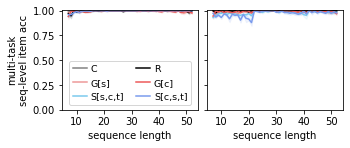

In [139]:
fig, axes = plt.subplots(1, 2, figsize=[4.8,2], sharey=True, sharex=True)

threshold = 'ge95' # 'eq100','ge95','ge90'

alpha = 0.8
task_display_name = {'C':0,'G[s]':2,'S[s,c,t]':3,'R':1,'G[c]':4,'S[c,s,t]':5} # display name to task index
colors = {'C':'grey','R':'black','G[s]':'#ed9898','G[c]':'#ed5858','S[s,c,t]':'#79c9ed','S[c,s,t]':'#799aed'}
w = 0.25
df_plot = seq_lvl_acc_df.groupby(['seq_len']).agg([np.mean, sp.stats.sem]).reset_index()

for i, (task_name, task_ind) in enumerate(task_display_name.items()):
    axes[0].plot(df_plot['seq_len'].values, df_plot['task%d_item_acc_%s'%(task_ind, threshold),'mean'].values, color=colors[task_name], label=task_name)
    axes[0].fill_between(df_plot['seq_len'].values, 
                         df_plot['task%d_item_acc_%s'%(task_ind, threshold),'mean'].values+df_plot['task%d_item_acc_%s'%(task_ind, threshold),'sem'].values, 
                         df_plot['task%d_item_acc_%s'%(task_ind, threshold),'mean'].values-df_plot['task%d_item_acc_%s'%(task_ind, threshold),'sem'].values, 
                         color=colors[task_name], alpha=0.1)

for i, (task_name, task_ind) in enumerate(task_display_name.items()):
    axes[1].plot(df_plot['seq_len'].values, df_plot['task%d_label_acc_%s'%(task_ind, threshold),'mean'].values, color=colors[task_name], label=task_name)
    axes[1].fill_between(df_plot['seq_len'].values, 
                         df_plot['task%d_label_acc_%s'%(task_ind, threshold),'mean'].values+df_plot['task%d_label_acc_%s'%(task_ind, threshold),'sem'].values, 
                         df_plot['task%d_label_acc_%s'%(task_ind, threshold),'mean'].values-df_plot['task%d_label_acc_%s'%(task_ind, threshold),'sem'].values, 
                         color=colors[task_name], alpha=0.1)

axes[0].legend(ncol=2, loc='lower center', prop={'size':9.5}, handlelength=1.5, handletextpad=0.4, columnspacing=1.2)
axes[0].set_ylim(0, 1.01)
axes[0].set_ylabel('multi-task\nseq-level item acc')
axes[0].set_xlabel('sequence length')
axes[1].set_xlabel('sequence length')
axes[0].set_xticks(range(10,51)[::10])

fig.tight_layout(pad=0.5)
# fig.savefig('../figure/v1/six_task_acc_by_len_top5_seqlvl_%s.pdf'%threshold)
# fig.savefig('../figure/v1/six_task_roacc_by_len_top5_seqlvl_%s.pdf'%threshold)

length generalization - token-level acc per extrapolation position

In [ ]:
def get_tf_pos_acc(model, runid, teacher_forcing=True):
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_val['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    accs = {}
    for metric in ['item', 'label']:
        for task in range(6):
            accs['task%d_%s_acc'%(task, metric)] = {p:[] for p in range(1,51)}
    
    tasks = batch_val['target']['item'][:,0,:7].argmax(-1) # task index
    for i in range(len(batch_val['src']['item'])): # for each seq,
        for p in range(1, seq_lens_val[i]-1): # compute acc for each position separately, ignoring <task> and <eos>
            pred, gt = item_pred[i,p], batch_val['target']['item'][i,p] # single token
            acc = (rearrange(pred[-15:], '(f d) -> f d', f=3).argmax(-1)==rearrange(gt[-15:], '(f d) -> f d', f=3).argmax(-1)).float().mean().cpu().numpy()
            accs['task%d_item_acc'%tasks[i]][p].append(acc)
            pred, gt = label_pred[i,p], batch_val['target']['label'][i,p] # single token
            acc = (pred[-50:].argmax()==gt[-50:].argmax()).float().cpu().numpy()
            accs['task%d_label_acc'%tasks[i]][p].append(acc)

    accs_df = {}
    for t in range(6):
        accs_df['task%d_item_acc'%t] = [np.mean(accs['task%d_item_acc'%t][p]) for p in range(1,51)]
        accs_df['task%d_label_acc'%t] = [np.mean(accs['task%d_label_acc'%t][p]) for p in range(1,51)]
    accs_df['seq_pos'] = range(1, 51)
    df_val = pd.DataFrame.from_dict(accs_df)
    df_val['phase'] = 'val'
    return df_val

In [ ]:
dfs = []
runids = max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values
for i, runid in enumerate(runids):
    epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
    step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
    ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
    model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
    
    df = get_tf_pos_acc(model, runid, teacher_forcing=False)
    df['runid'] = runid
    dfs.append(df)

# token_acc_by_pos = pd.concat(dfs)
# pkl.dump(token_acc_by_pos, open('temp_pkl_files/six_task_token_acc_by_pos.pkl','wb'))

token_roacc_by_pos = pd.concat(dfs)
# pkl.dump(token_roacc_by_pos, open('temp_pkl_files/six_task_token_roacc_by_pos.pkl','wb'))

In [126]:
token_acc_by_pos = pkl.load(open('temp_pkl_files/six_task_token_acc_by_pos.pkl','rb'))

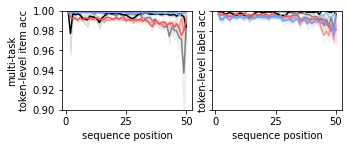

In [132]:
fig, axes = plt.subplots(1, 2, figsize=[4.8,2], sharey=True, sharex=True)

alpha = 0.8
task_display_name = {'C':0,'G[s]':2,'S[s,c,t]':3,'R':1,'G[c]':4,'S[c,s,t]':5} # display name to task index
colors = {'C':'grey','R':'black','G[s]':'#ed9898','G[c]':'#ed5858','S[s,c,t]':'#79c9ed','S[c,s,t]':'#799aed'}
w = 0.25
df_plot = token_acc_by_pos.groupby(['seq_pos']).agg([np.mean, sp.stats.sem]).reset_index()

for i, (task_name, task_ind) in enumerate(task_display_name.items()):
    axes[0].plot(df_plot['seq_pos'].values, df_plot['task%d_item_acc'%(task_ind),'mean'].values, color=colors[task_name], label=task_name)
    axes[0].fill_between(df_plot['seq_pos'].values, 
                         df_plot['task%d_item_acc'%(task_ind),'mean'].values+df_plot['task%d_item_acc'%(task_ind),'sem'].values, 
                         df_plot['task%d_item_acc'%(task_ind),'mean'].values-df_plot['task%d_item_acc'%(task_ind),'sem'].values, 
                         color=colors[task_name], alpha=0.1)

for i, (task_name, task_ind) in enumerate(task_display_name.items()):
    axes[1].plot(df_plot['seq_pos'].values, df_plot['task%d_label_acc'%(task_ind),'mean'].values, color=colors[task_name], label=task_name)
    axes[1].fill_between(df_plot['seq_pos'].values, 
                         df_plot['task%d_label_acc'%(task_ind),'mean'].values+df_plot['task%d_label_acc'%(task_ind),'sem'].values, 
                         df_plot['task%d_label_acc'%(task_ind),'mean'].values-df_plot['task%d_label_acc'%(task_ind),'sem'].values, 
                         color=colors[task_name], alpha=0.1)

# axes[0].legend(ncol=2, loc='lower center', prop={'size':9.5}, handlelength=1.5, handletextpad=0.4, columnspacing=1.2)
axes[0].set_ylim(0.9,1)
axes[0].set_yticks([0.90,0.92,0.94,0.96,0.98,1.00])
axes[0].set_ylabel('multi-task\ntoken-level item acc')
axes[1].set_ylabel('token-level label acc')
axes[0].set_xlabel('sequence position')
axes[1].set_xlabel('sequence position')
axes[0].set_xticks([0,25,50])

fig.tight_layout(pad=0.5)
# fig.savefig('../figure/v1/six_task_token_acc_by_pos.pdf')
# fig.savefig('../figure/v1/six_task_token_roacc_by_pos.pdf')

length genrealization - eos detection

In [ ]:
def get_tf_eos_acc(model, runid, teacher_forcing=True):
    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_train['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_train_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    eos_accs = {}
    for task in range(6):
        eos_accs['task%d_eos_acc'%task] = {p:[] for p in range(6,27)}
    
    tasks = batch_train['target']['item'][:,0,:7].argmax(-1) # task index
    for i in range(len(batch_train['src']['item'])): # for each seq, compute <eos> acc
        p = seq_lens_train[i]-1
        pred, gt = item_pred[i,p], batch_train['target']['item'][i,p] # eos token
        acc = (pred[:7].argmax()==gt[:7].argmax()).float().cpu().numpy()
        eos_accs['task%d_eos_acc'%tasks[i]][p].append(acc)

    accs_df = {}
    for t in range(6):
        accs_df['task%d_eos_acc'%t] = [np.mean(eos_accs['task%d_eos_acc'%t][p]) for p in range(6,27)]
    accs_df['seq_pos'] = range(6, 27)
    df_train = pd.DataFrame.from_dict(accs_df)
    df_train['phase'] = 'train'

    with torch.no_grad():
        if teacher_forcing:
            item_pred, label_pred = model.forward_teacher_forcing(batch_val['src'])
        else:
            x = pkl.load(open('temp_pkl_files/ro_val_batch_pred_%s.pkl'%runid,'rb'))
            item_pred, label_pred = x['item_pred'], x['label_pred']
    eos_accs = {}
    for task in range(6):
        eos_accs['task%d_eos_acc'%task] = {p:[] for p in range(27,52)}
    
    tasks = batch_val['target']['item'][:,0,:7].argmax(-1) # task index
    for i in range(len(batch_val['src']['item'])): # for each seq, compute <eos> acc
        p = seq_lens_val[i]-1
        pred, gt = item_pred[i,p], batch_val['target']['item'][i,p] # eos token
        acc = (pred[:7].argmax()==gt[:7].argmax()).float().cpu().numpy()
        eos_accs['task%d_eos_acc'%tasks[i]][p].append(acc)

    accs_df = {}
    for t in range(6):
        accs_df['task%d_eos_acc'%t] = [np.mean(eos_accs['task%d_eos_acc'%t][p]) for p in range(27,52)]
    accs_df['seq_pos'] = range(27, 52)
    df_val = pd.DataFrame.from_dict(accs_df)
    df_val['phase'] = 'val'

    return pd.concat([df_train, df_val])

In [ ]:
dfs = []
runids = max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values
for i, runid in enumerate(runids):
    epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
    step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
    ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
    model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
    
    df = get_tf_eos_acc(model, runid, teacher_forcing=False)
    df['runid'] = runid
    dfs.append(df)
# eos_acc_by_pos = pd.concat(dfs)
# pkl.dump(eos_acc_by_pos, open('temp_pkl_files/six_task_eos_acc_by_pos.pkl','wb'))
eos_roacc_by_pos = pd.concat(dfs)
pkl.dump(eos_roacc_by_pos, open('temp_pkl_files/six_task_eos_roacc_by_pos.pkl','wb'))

In [ ]:
eos_roacc_by_pos = pkl.load(open('temp_pkl_files/six_task_eos_roacc_by_pos.pkl', 'rb'))

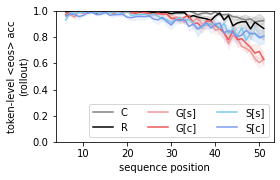

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[4,2.6], sharey=True, sharex=True)

alpha = 0.8
task_display_name = {'C':0, 'R':1, 'G[s]':2,'G[c]':4,'S[s]':3,'S[c]':5} # display name to task index
colors = ['grey','black','#ed9898','#ed5858','#79c9ed','#799aed']
w = 0.25
df_plot = eos_roacc_by_pos.groupby(['seq_pos']).agg([np.mean, sp.stats.sem]).reset_index()

for i, (task_name, task_ind) in enumerate(task_display_name.items()):
    ax.plot(df_plot['seq_pos'].values, df_plot['task%d_eos_acc'%(task_ind),'mean'].values, color=colors[i], label=task_name)
    ax.fill_between(df_plot['seq_pos'].values, 
                         df_plot['task%d_eos_acc'%(task_ind),'mean'].values+df_plot['task%d_eos_acc'%(task_ind),'sem'].values, 
                         df_plot['task%d_eos_acc'%(task_ind),'mean'].values-df_plot['task%d_eos_acc'%(task_ind),'sem'].values, 
                         color=colors[i], alpha=0.1)

ax.legend(ncol=3, loc='lower right')
ax.set_ylim(0,1)
ax.set_ylabel('token-level <eos> acc\n(rollout)')
ax.set_xlabel('sequence position')

fig.tight_layout()
# fig.savefig('../figure/v1/six_task_eos_roacc_by_pos.pdf')

task modularity: ablated forward

In [47]:
max_val_acc_df.sort_values('val/label_acc').tail(5)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,epoch,trainer/global_step,val/item_acc,val/label_acc,val/task0_item_acc,val/task0_label_acc,...,val/task3_item_acc,val/task3_label_acc,val/task4_item_acc,val/task4_label_acc,val/task5_item_acc,val/task5_label_acc,runid,embed_dim,n_head_l0,n_head_l1
29,29,29.0,165.0,NaN,16,35539,0.994624,0.993003,0.996970,0.998518,...,0.998571,0.991156,0.989718,0.993464,0.996655,0.985617,35xuro1q,192,1,4
18,18,18.0,18.0,151.0,15,32542,0.994533,0.994422,0.993658,0.998191,...,0.997050,0.990642,0.991602,0.995410,0.999171,0.992575,2wfk0wr3,192,1,6
8,8,8.0,8.0,150.0,15,32328,0.995760,0.995660,0.997808,0.998953,...,0.998891,0.993569,0.993436,0.996168,0.998417,0.993698,3iec955a,192,4,4
27,27,27.0,172.0,NaN,17,37038,0.994263,0.996011,0.995084,0.998084,...,0.998862,0.996841,0.989432,0.994370,0.997634,0.993573,1hgg0cd1,192,6,6
16,16,16.0,16.0,160.0,16,34469,0.997591,0.997613,0.996647,0.999016,...,0.999507,0.996503,0.996377,0.997659,0.999580,0.997297,3cyk4n4w,192,1,4


In [48]:
device='cuda:4'
runid='3cyk4n4w'
model_task_list = config_list[id_list.index(runid)]['dataset']['use_tasks']
model, datamodule = utils.reconstruct_model_and_dm(local_run_root=LOCAL_RUN_ROOT, 
                                                   runid=runid, 
                                                   config=config_list[id_list.index(runid)],
                                                   batch_size=200*len(model_task_list),
                                                   train_idx=runs[runs['id']==runid]['data.train_idx'].values[0],
                                                   val_idx=runs[runs['id']==runid]['data.val_idx'].values[0])
_ = model.to(device)
for batch in datamodule.val_dataloader(): break
batch = utils.batch_to_device(batch, device, except_keys=['task'])

In [62]:
with torch.no_grad():
    # processed_batch = model.process_batch(batch, teacher_forcing=True)
    # item_pred, label_pred = model.forward_teacher_forcing(processed_batch['src'])
    processed_batch = model.process_batch(batch, teacher_forcing=False)
    item_pred, label_pred = model.forward_rollout(processed_batch['src'])
    result_dict = {'pred': {'item': item_pred, 
                            'label': label_pred},
                   'target': {'item': processed_batch['target']['item'], 
                              'label': processed_batch['target']['label']}}
_, orig_acc = model._calc_loss_acc(result_dict)

In [ ]:
result_dict, _ = model.ablated_forward(ablate_head_list=[[],[1]], batch=batch, teacher_forcing=True)
_, acc = model._calc_loss_acc(result_dict)

In [95]:
item_pred, item_gt = result_dict['pred']['item'], result_dict['target']['item']
label_pred, label_gt = result_dict['pred']['label'], result_dict['target']['label']

# turn logits to onehot
item_pred_onehot = rearrange(F.one_hot(rearrange(item_pred[:, 1:, 7:], 'b n (f d) -> b n f d', f=3).argmax(-1), num_classes=5), 'b n f d -> b n (f d)')

In [106]:
tasks = ['copy', 'reverse', 'group[shape]', 'sort[shape]', 'group[color]', 'sort[color]']

Text(0.5, 0.98, 'sort[color]')

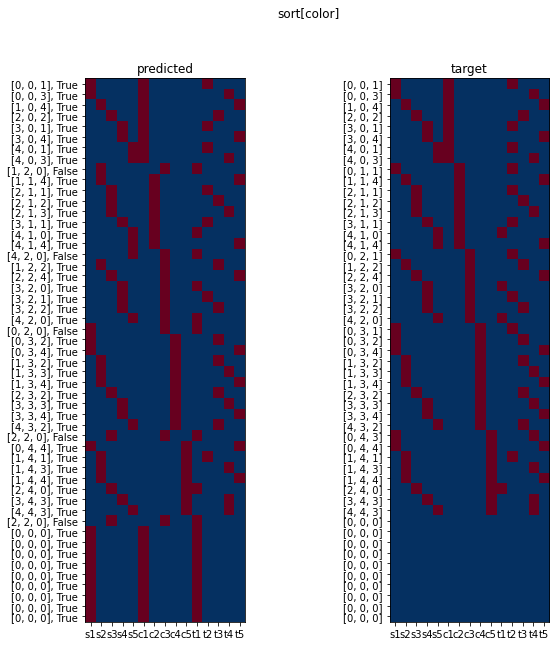

In [119]:
i = 5

fig, axes = plt.subplots(1, 2, figsize=[10,10], sharex=True)
axes[0].set_title('predicted')
axes[0].imshow(item_pred_onehot[i].cpu())
axes[1].set_title('target')
axes[1].imshow(item_gt[i, 1:, 7:].cpu())

item_pred_int = [str(x.numpy().tolist()) for x in rearrange(item_pred_onehot[i, :, :].cpu(), 'n (f d) -> n f d', f=3).argmax(-1)]
item_gt_int = [str(x.numpy().tolist()) for x in rearrange(item_gt[i, 1:, 7:].cpu(), 'n (f d) -> n f d', f=3).argmax(-1)]
acc = [np.all(item_pred_int[i]==item_gt_int[i]) for i in range(len(item_pred_int))]

axes[0].set_yticks(range(len(item_pred_int)))
axes[0].set_yticklabels([item_pred_int[i]+', '+str(acc[i]) for i in range(len(item_pred_int))])
axes[0].set_xticks(range(15))
axes[0].set_xticklabels(['s1','s2','s3','s4','s5','c1','c2','c3','c4','c5','t1','t2','t3','t4','t5'])

axes[1].set_yticks(range(len(item_gt_int)))
_ = axes[1].set_yticklabels(item_gt_int)

fig.suptitle(tasks[item_gt[i, 0, :7].detach().cpu().argmax()])

In [63]:
ablation_by_head_acc = {}

layer_idx = 0
for head_idx in range(model.hparams.n_heads[layer_idx]):
    result_dict = model.ablated_forward(ablate_head_list=[[head_idx],[]], batch=batch, teacher_forcing=False)
    _, acc = model._calc_loss_acc(result_dict)
    ablation_by_head_acc['L%d-H%d'%(layer_idx, head_idx)] = acc

layer_idx = 1
for head_idx in range(model.hparams.n_heads[layer_idx]):
    result_dict = model.ablated_forward(ablate_head_list=[[],[head_idx]], batch=batch, teacher_forcing=False)
    _, acc = model._calc_loss_acc(result_dict)
    ablation_by_head_acc['L%d-H%d'%(layer_idx, head_idx)] = acc

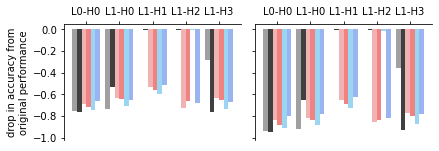

In [65]:
fig, axes = plt.subplots(1, 2, figsize=[6.2,2.2], sharey=True)

task_display_name = {'C':0, 'R':1, 'G[s]':2,'G[c]':4,'S[s]':3,'S[c]':5} # display name to task index
colors = ['grey','black','#ed9898','#ed5858','#79c9ed','#799aed']

for i, metric in enumerate(['item', 'label']):
    ax = axes[i]
    jitter = [-0.35, -0.21, -0.07, 0.07, 0.21, 0.35]

    for j, (task_name, task_ind) in enumerate(task_display_name.items()):
        accs = [ablation_by_head_acc[ablation]['task%d_%s_acc'%(task_ind,metric)].cpu() for ablation in ablation_by_head_acc]
        ax.bar(np.arange(sum(model.hparams.n_heads))+jitter[j], np.array(accs) - orig_acc['task%d_%s_acc'%(task_ind, metric)].cpu().numpy(), 
               color=colors[j], width=0.14, alpha=0.75, label=task_name)
    
    ax.spines[['right', 'bottom']].set_visible(False)
    ax.set_xticks(range(sum(model.hparams.n_heads)))
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels(ablation_by_head_acc.keys())

# axes[0].legend(loc='lower right', ncol=3)
axes[0].set_yticks([-1.0, -0.8, -0.6, -0.4, -0.2, 0])
axes[0].set_ylim([-1.02, 0.05])
axes[0].set_ylabel('drop in accuracy from\noriginal performance')
fig.tight_layout()

# fig.savefig('../figure/v1/%s/ablated_acc_by_head.pdf'%runid)
# fig.savefig('../figure/v1/%s/ablated_roacc_by_head.pdf'%runid)

In [ ]:
ablation_by_type_acc = {}

specs = {'none': {},
         'task': {'keep_attn_to_task':[True,True]},
         'next': {'keep_attn_to_next':[True,True]},
         'task+next': {'keep_attn_to_task':[True,True], 'keep_attn_to_next':[True,True]},
         'taskL0+nextL1': {'keep_attn_to_task':[True,False], 'keep_attn_to_next':[False,True]},
         'task+next+eos': {'keep_attn_to_task':[True,True], 'keep_attn_to_next':[True,True], 'keep_attn_to_eos':[True,True]},
         'task+next+shape+eos': {'keep_attn_to_task':[True,True], 'keep_attn_to_next':[True,True], 'keep_attn_to_eos':[True,True], 'keep_attn_to_same_shape':[True,True]},
         'task+next+color+eos': {'keep_attn_to_task':[True,True], 'keep_attn_to_next':[True,True], 'keep_attn_to_eos':[True,True], 'keep_attn_to_same_color':[True,True]},
         }

for ablation in specs.keys():
    result_dict = model.ablated_forward(ablate_head_list=[list(range(model.hparams.n_heads[0])),list(range(model.hparams.n_heads[1]))], 
                                                   batch=batch, teacher_forcing=False, **specs[ablation])
    _, acc = model._calc_loss_acc(result_dict)
    ablation_by_type_acc[ablation] = acc

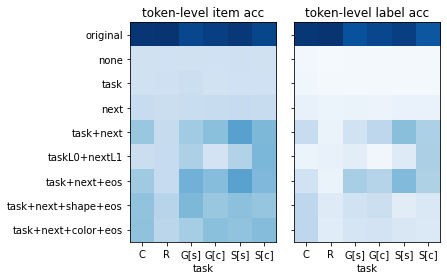

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=[6.5,4], sharex=True, sharey=True)

task_display_name = {'C':0, 'R':1, 'G[s]':2,'G[c]':4,'S[s]':3,'S[c]':5} # display name to task index
for i, metric in enumerate(['item', 'label']):
    ax = axes[i]
    ax.set_title('token-level %s acc' % metric)

    accs = [[orig_acc['task%d_%s_acc'%(t,metric)].cpu() for t in task_display_name.values()]]
    labels = ['original']
    for ablation in ablation_by_type_acc.keys():
        labels.append(ablation)
        accs.append([ablation_by_type_acc[ablation]['task%d_%s_acc'%(t,metric)].cpu() for t in task_display_name.values()])
    accs = np.array(accs)

    im = ax.imshow(accs, vmin=0, vmax=1, cmap='Blues')
    ax.set_yticks(range(len(labels)))
    _ = ax.set_yticklabels(labels)
    ax.set_xticks(range(6))
    _ = ax.set_xticklabels(task_display_name.keys())
    ax.set_xlabel('task')

fig.tight_layout()
# fig.savefig('../figure/v1/%s/ablated_roacc_by_type.pdf'%runid)

In [ ]:
def ablate_acc_at_ckpt(model):
    ablation_by_type_acc = {}

    with torch.no_grad():
        result_dict = model.forward(batch)
    _, orig_acc = model._calc_loss_acc(result_dict)
    ablation_by_type_acc['original'] = orig_acc

    specs = {'task+next+eos': {'keep_attn_to_task':[True,True], 'keep_attn_to_next':[True,True], 'keep_attn_to_eos':[True,True]},
             'task+next+shape+eos': {'keep_attn_to_task':[True,True], 'keep_attn_to_next':[True,True], 'keep_attn_to_same_shape':[True,True], 'keep_attn_to_eos':[True,True]},
             'task+next+color+eos': {'keep_attn_to_task':[True,True], 'keep_attn_to_next':[True,True], 'keep_attn_to_same_color':[True,True], 'keep_attn_to_eos':[True,True]}
            }
    for ablation in specs.keys():
        result_dict, attn_maps = model.ablated_forward(ablate_head_list=[list(range(model.hparams.n_heads[0])),list(range(model.hparams.n_heads[1]))], 
                                                       batch=batch, batch_processed=False, teacher_forcing=True, **specs[ablation])
        _, acc = model._calc_loss_acc(result_dict)
        ablation_by_type_acc[ablation] = acc

    return ablation_by_type_acc

def ablate_acc_over_ckpts(runid):
    ckpts = utils.get_ckptfs_from_run(ckpt_dir=LOCAL_RUN_ROOT, runid=runid)
    ckpts = ckpts[ckpts['step']<38000][::11]
    result = list(map(lambda f: ablate_acc_at_ckpt(utils.load_model(MultitaskModelModule, f).to(device)), ckpts.fname.values))
    pkl.dump((result, ckpts), open('temp_pkl_files/%s_ablated_acc_over_learning.pkl'%runid,'wb'))
    return result, ckpts

In [ ]:
results = []
ckpts = []
for runid in max_val_acc_df.sort_values('val/label_acc').tail(5).runid.values:
    print(runid)
    res, ck = ablate_acc_over_ckpts(runid)
    results.append(res)
    ckpts.append(ck)

35xuro1q
2wfk0wr3
3iec955a
1hgg0cd1
3cyk4n4w


In [ ]:
results[2].append({abla:{k:torch.tensor(float('nan')) for k in results[0][0]['original']} for abla in results[0][0].keys()})

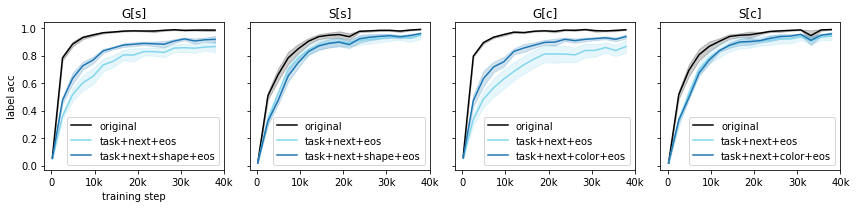

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=[12,3], sharex=True, sharey=True)

ablations = {'G[s]':['original', 'task+next+eos', 'task+next+shape+eos'],
             'S[s]':['original', 'task+next+eos', 'task+next+shape+eos'],
             'G[c]':['original', 'task+next+eos', 'task+next+color+eos'],
             'S[c]':['original', 'task+next+eos', 'task+next+color+eos'],}
metrics = {'G[s]':'task2_label_acc', 'S[s]':'task3_label_acc', 'G[c]':'task4_label_acc', 'S[c]':'task5_label_acc'}
colors = ['black','#82d6ed','C0']

for i, task in enumerate(metrics.keys()):
    ax = axes[i]
    ax.set_title(task)
    for a, ablation in enumerate(ablations[task]):
        accs = np.array([[ckpt_accs[ablation][metrics[task]].cpu() for ckpt_accs in result] for i, result in enumerate(results)])
        means = np.nanmean(accs, 0)
        sems = sp.stats.sem(accs, nan_policy='omit')
        ax.plot(ckpts[0]['step'].values, means, color=colors[a], label=ablation)
        ax.fill_between(ckpts[0]['step'].values, means+sems, means-sems, color=colors[a], alpha=0.2)
    
    ax.legend()

axes[0].set_ylabel('label acc')
axes[0].set_xlabel('training step')
axes[0].set_xticks([0,10000,20000,30000,40000])
axes[0].set_xticklabels(['0','10k','20k','30k','40k'])

fig.tight_layout()
# fig.savefig('../figure/v1/six_task_ablated_acc_over_learning_top5.pdf')

attention maps

In [6]:
def extract_and_reorder_attn_maps(model, batch, batch_idx):

    '''
    plots the attention weights for one sequence in batch, 
    query (y-axis) starts from the <eos> after input seq (first query) and ends at the last item in output seq (last query)
    source includes both input and output sequences
    '''

    depth = model.hparams.depth
    n_head = model.hparams.n_heads
    n_task = model.hparams.n_task
    n_feature = model.hparams.n_feature
    include_task_token = model.hparams.use_task_token

    if type(n_head)==int: n_head = [n_head]*depth

    # extract one sequence at batch_idx as a batch
    seq_lens = model._calc_batch_seq_len(batch['src']['item'], teacher_forcing=True)
    seq_len = seq_lens[batch_idx]
    mini_batch = {'src': {'task': batch['src']['task'][batch_idx:batch_idx+1, :],
                          'item': batch['src']['item'][batch_idx:batch_idx+1, :seq_len*2], # (1, seq_len*2, item_dim)
                          'label': batch['src']['label'][batch_idx:batch_idx+1, :seq_len*2]}}

    # generate first-level labels and sort index (used to label items and reorder attention maps for viz)
    if not include_task_token:
        seq = rearrange(mini_batch['src']['item'][0,:seq_len,n_task+1:], 'l (f d) -> l f d', f=n_feature).argmax(-1)
        sorted_seq = rearrange(mini_batch['src']['item'][0,seq_len:seq_len*2,n_task+1:], 'l (f d) -> l f d', f=n_feature).argmax(-1)
    else:
        seq = rearrange(mini_batch['src']['item'][0,1:seq_len,n_task+1:], 'l (f d) -> l f d', f=n_feature).argmax(-1)
        sorted_seq = rearrange(mini_batch['src']['item'][0,seq_len+1:seq_len*2,n_task+1:], 'l (f d) -> l f d', f=n_feature).argmax(-1)
    sort_idx = [seq.cpu().numpy().tolist().index(sorted_item) for sorted_item in sorted_seq.cpu().numpy().tolist()] # include <eos>

    attention_maps = model.get_attention_maps(mini_batch, batch_processed=True, teacher_forcing=True) # list of (1, n_head, seq_len*2, seq_len*2)
    attention_maps = [x[0] for x in attention_maps] # list of (n_head, seq_len*2, seq_len*2)

    reordered_maps = {}
    for l in range(depth):
        for h in range(n_head[l]):

            maps = attention_maps[l][h, :].cpu() # (n_item*2, n_item*2)
            if not include_task_token:
                maps[:seq_len,:seq_len] = maps[:seq_len,:seq_len][sort_idx,:][:,sort_idx] # unsorted portion attending to unsorted portion
                maps[seq_len:,:seq_len] = maps[seq_len:,:seq_len][:,sort_idx] # sorted portion attending to unsorted portion
            else:
                maps[1:seq_len,1:seq_len] = maps[1:seq_len,1:seq_len][sort_idx,:][:,sort_idx]
                maps[seq_len+1:, 1:seq_len] = maps[seq_len+1:, 1:seq_len][:,sort_idx]
            reordered_maps['L%d-H%d'%(l,h)] = maps

    return reordered_maps, sorted_seq # sorted_seq does not include task token

def plot_attn_maps(model, batch, batch_idx, task_str, figsize):

    reordered_attn_maps, sorted_seq = extract_and_reorder_attn_maps(model, batch, batch_idx)
    print(reordered_attn_maps['L0-H0'].shape)
    seq_len = len(sorted_seq)

    depth = model.hparams.depth
    n_head = model.hparams.n_heads
    n_task = model.hparams.n_task
    n_feature = model.hparams.n_feature
    include_task_token = model.hparams.use_task_token
    if type(n_head)==int: n_head = [n_head]*depth

    fig, axes = plt.subplots(1, sum(n_head), figsize=figsize)

    for l in range(depth):
        for h in range(n_head[l]):
            ax = axes[sum(n_head[:l])+h] # axes[l, h] if max(n_head)>1 else axes[l]
            ax.set_title('L%d-H%d'%(l,h))

            im=ax.imshow(reordered_attn_maps['L%d-H%d'%(l,h)], cmap='RdBu_r', 
                         vmin=0, vmax=1, norm=mplcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1))

            if task_str in ['sort_by_shape','sort_by_shape_first']: cluster = sorted_seq[:,0].cpu().numpy()
            elif task_str in ['sort_by_color','sort_by_color_first']: cluster = sorted_seq[:,1].cpu().numpy()
            else: cluster = list(range(len(sorted_seq)))
            cluster[-1] = 9
            begin_of_cluster = np.unique(cluster, return_index=True)[1].tolist()

            if 'sort' in task_str:
                if include_task_token:
                    ax.set_xticks([0]+[1+x for x in begin_of_cluster]+[seq_len+1]+[seq_len+2+x for x in begin_of_cluster])
                    ax.set_yticks([0]+[1+x for x in begin_of_cluster]+[seq_len+1]+[seq_len+2+x for x in begin_of_cluster])
                    labels = ['t'] + [str(cluster[i]+1) for i in begin_of_cluster]
                    labels[-1] = 'e'
                    ax.set_xticklabels(labels*2)
                    labels[0] = 't  '
                    ax.set_yticklabels(labels*2)
                else:
                    ax.set_xticks([x for x in begin_of_cluster]+[seq_len+x for x in begin_of_cluster])
                    ax.set_yticks([x for x in begin_of_cluster]+[seq_len+x for x in begin_of_cluster])
                    labels = [str(cluster[i]+1) for i in begin_of_cluster]
                    labels[-1] = 'e'
                    ax.set_xticklabels(labels*2)
                    ax.set_yticklabels(labels*2)

            else:
                if include_task_token:
                    ax.set_xticks([0,seq_len,seq_len+1,seq_len*2+1])
                    ax.set_xticklabels(['t','e','t','e'])
                    ax.set_yticks([0,seq_len,seq_len+1,seq_len*2+1])
                    ax.set_yticklabels(['t','e','t','e'])
                else:
                    ax.set_xticks([seq_len-1,seq_len*2-1])
                    ax.set_xticklabels(['e','e'])
                    ax.set_yticks([seq_len-1,seq_len*2-1])
                    ax.set_yticklabels(['e','e'])

    ax = axes[0] # axes[-1,0] if max(n_head)>1 else axes[-1]
    ax.set_ylabel('query item')
    ax.set_xlabel('source item')

    # fig.subplots_adjust(right=0.98)
    # cbar_ax = fig.add_axes([0.98, 0.25, 0.02, 0.5])
    # fig.colorbar(im, cax=cbar_ax)

    fig.suptitle('depth: %d    '%depth+' n_heads: %s    '%str(np.array(n_head))+'task: '+task_str)
    # fig.subplots_adjust(wspace=-0.5)
    fig.tight_layout()

    return fig, ax

In [ ]:
max_val_acc_df.sort_values('val/label_acc').tail(10)[['val/item_acc','val/label_acc','runid','n_head_l0','n_head_l1']]

,val/item_acc,val/label_acc,runid,n_head_l0,n_head_l1
10,0.987076,0.989339,173w6fac,6,6
17,0.993050,0.989823,ki21vp2h,1,4
30,0.992059,0.991623,25xhs6v2,1,6
11,0.993116,0.992523,3q52c0zq,6,6
31,0.994060,0.992645,1bm6gsc6,1,6
29,0.994624,0.993003,35xuro1q,1,4
18,0.994533,0.994422,2wfk0wr3,1,6
8,0.995760,0.995660,3iec955a,4,4
27,0.994263,0.996011,1hgg0cd1,6,6
16,0.997591,0.997613,3cyk4n4w,1,4


In [7]:
device = 'cuda:4'
runid = '3cyk4n4w'
model, datamodule = utils.reconstruct_model_and_dm(local_run_root=LOCAL_RUN_ROOT, 
                                                   runid=runid, 
                                                   config=config_list[id_list.index(runid)],
                                                   train_idx=runs[runs['id']==runid]['data.train_idx'].values[0],
                                                   val_idx=runs[runs['id']==runid]['data.val_idx'].values[0])
model.to(device)
for batch in datamodule.val_dataloader(): break
tasks = batch['task']
batch = utils.batch_to_device(batch, device, except_keys=['task'])
batch = model.process_batch(batch, teacher_forcing=True)

task:  sort_by_color_first
torch.Size([56, 56])


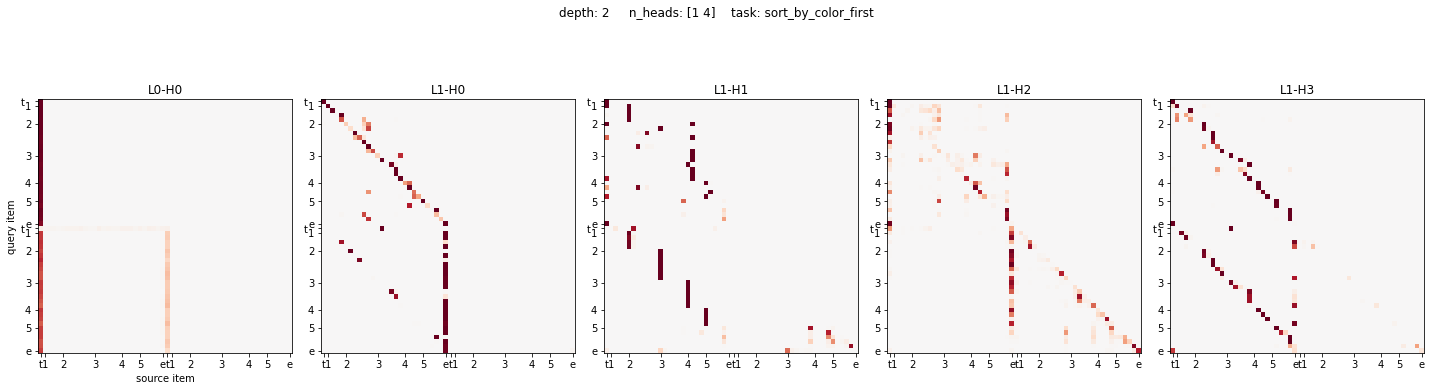

In [ ]:
i = 137
print('task: ', tasks[i])
fig, axes = plot_attn_maps(model, batch, batch_idx=i, task_str=tasks[i], figsize=[20,6])
# fig.savefig('../figure/v1/%s/val_ex_attn_map_%s.pdf'%(runid,tasks[i]))

torch.Size([56, 56])
depth: 2     n_heads: [1 4]    task: sort_by_color


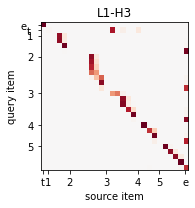

In [10]:
# single head
batch_idx=136
task_str=tasks[batch_idx]
figsize=[3,3]
l=1
h=3

reordered_attn_maps, sorted_seq = extract_and_reorder_attn_maps(model, batch, batch_idx)
print(reordered_attn_maps['L0-H0'].shape)
seq_len = len(sorted_seq)

depth = model.hparams.depth
n_head = model.hparams.n_heads
n_task = model.hparams.n_task
n_feature = model.hparams.n_feature
include_task_token = model.hparams.use_task_token
if type(n_head)==int: n_head = [n_head]*depth

fig, ax = plt.subplots(1, figsize=figsize)
ax.set_title('L%d-H%d'%(l,h))

im=ax.imshow(reordered_attn_maps['L%d-H%d'%(l,h)][seq_len:-1, :seq_len+1], cmap='RdBu_r', 
             vmin=0, vmax=1, norm=mplcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1))

if task_str in ['sort_by_shape','sort_by_shape_first']: cluster = sorted_seq[:,0].cpu().numpy()
elif task_str in ['sort_by_color','sort_by_color_first']: cluster = sorted_seq[:,1].cpu().numpy()
else: cluster = list(range(len(sorted_seq)))
cluster[-1] = 9
begin_of_cluster = np.unique(cluster, return_index=True)[1].tolist()

ax.set_xticks([0]+[1+x for x in begin_of_cluster])# +[seq_len+1]+[seq_len+2+x for x in begin_of_cluster])
ax.set_yticks([0,1]+[2+x for x in begin_of_cluster[:-1]])
ax.set_xticklabels(['t', '1', '2', '3', '4', '5', 'e'])
ax.set_yticklabels(['e  ', 't ', '1', '2', '3', '4', '5'])

ax.set_ylabel('query item')
ax.set_xlabel('source item')

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='4%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')

print('depth: %d    '%depth+' n_heads: %s    '%str(np.array(n_head))+'task: '+task_str)
# fig.subplots_adjust(wspace=-0.5)
fig.tight_layout()

# fig.savefig('../figure/v1/%s/val_ex_attn_map_L%d-H%d_%s.pdf'%(runid,l,h,task_str))

task embeddings

In [ ]:
max_val_acc_df.sort_values('val/label_acc').tail(5)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,epoch,trainer/global_step,val/item_acc,val/label_acc,val/task0_item_acc,val/task0_label_acc,...,val/task3_item_acc,val/task3_label_acc,val/task4_item_acc,val/task4_label_acc,val/task5_item_acc,val/task5_label_acc,runid,embed_dim,n_head_l0,n_head_l1
29,29,29.0,165.0,NaN,16,35539,0.994624,0.993003,0.996970,0.998518,...,0.998571,0.991156,0.989718,0.993464,0.996655,0.985617,35xuro1q,192,1,4
18,18,18.0,18.0,151.0,15,32542,0.994533,0.994422,0.993658,0.998191,...,0.997050,0.990642,0.991602,0.995410,0.999171,0.992575,2wfk0wr3,192,1,6
8,8,8.0,8.0,150.0,15,32328,0.995760,0.995660,0.997808,0.998953,...,0.998891,0.993569,0.993436,0.996168,0.998417,0.993698,3iec955a,192,4,4
27,27,27.0,172.0,NaN,17,37038,0.994263,0.996011,0.995084,0.998084,...,0.998862,0.996841,0.989432,0.994370,0.997634,0.993573,1hgg0cd1,192,6,6
16,16,16.0,16.0,160.0,16,34469,0.997591,0.997613,0.996647,0.999016,...,0.999507,0.996503,0.996377,0.997659,0.999580,0.997297,3cyk4n4w,192,1,4


In [40]:
device = 'cuda:4'
from sklearn import metrics

In [41]:
def get_task_embedding(model):
    # task order in dataset is ['copy','reverse','sort_by_shape','sort_by_shape_first','sort_by_color','sort_by_color_first']
    # will use ['copy','reverse','sort_by_shape','sort_by_color','sort_by_shape_first','sort_by_color_first'] in figures
    tasks = F.one_hot(torch.tensor([0,1,2,4,3,5]), num_classes=model.hparams.item_dim).to(model.device)
    with torch.no_grad():
        task_embeddings = model.transformer.task_embed(tasks.float()).cpu().numpy()
    return task_embeddings

task_embeddings = []
for runid in max_val_acc_df.sort_values('val/label_acc').tail(5)['runid'].values:
    epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
    step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
    ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
    model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
    task_embeddings.append(get_task_embedding(model))
task_sims = np.array([sklearn.metrics.pairwise.cosine_similarity(x) for x in task_embeddings])

-0.065393664


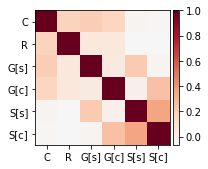

In [46]:
fig, ax = plt.subplots(1, figsize=[3,3])
print(task_sims.mean(0).min()) # should be very close to zero, so setting the min to 'whitest' in cmap
im = ax.imshow(task_sims.mean(0), vmin=task_sims.mean(0).min(), vmax=1, 
               norm=mplcolors.TwoSlopeNorm(vmin=task_sims.mean(0).min()-0.01, vcenter=task_sims.mean(0).min(), vmax=1))

ax.set_yticks(range(6))
_ = ax.set_yticklabels(['C','R','G[s]','G[c]','S[s]','S[c]'])
ax.set_xticks(range(6))
_ = ax.set_xticklabels(['C','R','G[s]','G[c]','S[s]','S[c]'])

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

fig.tight_layout()
# fig.savefig('../figure/v1/six_task_task_embedding_cossim.pdf')

In [ ]:
dfs = []
for i, runid in enumerate(max_val_acc_df[max_val_acc_df['val/label_acc']>=0.99]['runid'].values):
    x = task_embeddings[i]
    sims = sklearn.metrics.pairwise.cosine_similarity(x)
    df = pd.DataFrame.from_records({'sim_gs_ss': [sims[2,4]], 'sim_gc_sc': [sims[3,5]]})
    df['runid'] = runid
    n_head_l0, n_head_l1 = config_list[id_list.index(runid)]['model']['n_heads']
    df['n_head_l0'] = n_head_l0
    df['n_head_l1'] = n_head_l1
    if n_head_l0 == n_head_l1:
        df['arch_type'] = 'balanced'
    elif n_head_l0 > n_head_l1:
        df['arch_type'] = 'frontload'
    else:
        df['arch_type'] = 'backload'
    dfs.append(df)
df = pd.concat(dfs)

In [ ]:
df.groupby('arch_type').mean()

,sim_gc_sc,sim_gs_ss,n_head_l0,n_head_l1
arch_type,,,,
backload,0.222406,0.221603,1.000000,5.200000
balanced,0.239674,0.218444,5.333333,5.333333


#### task-conditioned contextualization of sequence

In [6]:
def embedding_matrix_to_dataframe(tasks, model, batch, encoded_reps):
    # extract item embeddings in the model for each seq x task x layer
    dfs = []
    n_tasks = model.hparams.n_task
    embed_dim = model.hparams.embed_dim
    for i in range(len(batch['seq'])): # go through each sequence
        task = tasks[i]
        unique_seq_idx = i//n_tasks # updates every n_tasks
        seq_len = int(sum(batch['seq'][i].sum(-1)!=0)) # counting <task> and <eos>

        # mark boundary items
        tokens = batch['seq'][i][:seq_len-1,n_tasks+1:].cpu().reshape(seq_len-1,3,5).argmax(-1) # <task> + all items without eos
        sorted_tokens = batch['out_seq'][i][:seq_len,n_tasks+1:].cpu().reshape(seq_len,3,5).argmax(-1) # <task> + all items + <eos>

        if ('shape' in task) or ('color' in task):
            cluster = sorted_tokens[1:,0].cpu().numpy().copy() if 'shape' in task else sorted_tokens[1:,1].cpu().numpy().copy() # skip the task token
            cluster[-1] = 9
            begin_of_cluster = np.unique(cluster, return_index=True)[1].tolist()
            boundary = ['task']+['begin' if i in begin_of_cluster and i != seq_len-2 else 'end' if i+1 in begin_of_cluster else 'other' for i in range(seq_len-1)]
        else: # copy or reverse
            boundary = ['n/a'] * seq_len

        # source seq (contains only items, no eos)
        token_types = np.array(['task'] + ['item']*(seq_len-2))
        labels = batch['random_label'][i,:seq_len-1,n_tasks+1:].argmax(-1).cpu()
        sort_idx = batch['sort_idx'][i,1:seq_len-1,n_tasks+1:].argmax(-1).cpu()
        # extract source embeddings and reorder
        input_embed = encoded_reps['input_embed'][i,:seq_len-1].cpu()
        l0_embed = encoded_reps['attn_embed'][0,i,:seq_len-1].cpu()
        l1_embed = encoded_reps['attn_embed'][1,i,:seq_len-1].cpu()
        input_embed[1:] = input_embed[1:][sort_idx]
        l0_embed[1:] = l0_embed[1:][sort_idx]
        l1_embed[1:] = l1_embed[1:][sort_idx]
        tokens[1:] = tokens[1:][sort_idx]
        labels[1:] = labels[1:][sort_idx]
        # put in a df
        df = pd.DataFrame(torch.cat([input_embed, l0_embed, l1_embed])) # (3*seq_len-1, embed_dim)
        df['seq'] = [unique_seq_idx]*(3*seq_len-3)
        df['task'] = [task]*(3*seq_len-3)
        df['layer'] = np.repeat(['input','L0','L1'], seq_len-1)
        df['source_probe_target'] = ['source']*(3*seq_len-3)
        df['item_type'] = np.tile(token_types, 3)
        df['out_pos'] = ([''] + list(range(seq_len-2)))*3
        df['boundary'] = np.tile(boundary[:-1], 3)
        df['shape'] = np.tile(tokens[:,0], 3)
        df['color'] = np.tile(tokens[:,1], 3)
        df['texture'] = np.tile(tokens[:,2], 3)
        df['label'] = np.tile(labels, 3)
        dfs.append(df)

        # query seq (labeled as input token, starts with eos)
        labels = batch['sorted_label'][i,:seq_len,n_tasks+1:].argmax(-1).cpu()
        tokens = torch.cat((sorted_tokens[-1:], sorted_tokens[:-1])) # shift eos to start
        labels = torch.cat((labels[-1:], labels[:-1])) # shift eos to start
        token_types = ['eos'] + ['task'] + ['item']*(seq_len-2)
        # extract query embeddings
        input_embed = encoded_reps['input_embed'][i,seq_len-1:2*seq_len-1].cpu()
        l0_embed = encoded_reps['attn_embed'][0,i,seq_len-1:2*seq_len-1].cpu()
        l1_embed = encoded_reps['attn_embed'][1,i,seq_len-1:2*seq_len-1].cpu()
        # put in a df
        df = pd.DataFrame(torch.cat([input_embed, l0_embed, l1_embed])) # (3*seq_len, embed_dim)
        df['seq'] = [unique_seq_idx]*(3*seq_len)
        df['task'] = [task]*(3*seq_len)
        df['layer'] = np.repeat(['input','L0','L1'], seq_len)
        df['source_probe_target'] = ['probe']*(3*seq_len)
        df['item_type'] = np.tile(token_types, 3)
        df['out_pos'] = (['']*2 + list(range(seq_len-2)))*3
        df['boundary'] = np.tile(boundary[-1:] + boundary[:-1], 3)
        df['shape'] = np.tile(tokens[:,0], 3)
        df['color'] = np.tile(tokens[:,1], 3)
        df['texture'] = np.tile(tokens[:,2], 3)
        df['label'] = np.tile(labels, 3)
        dfs.append(df)

        # query seq (labeled as output token, ends with eos)
        labels = batch['sorted_label'][i,:seq_len,n_tasks+1:].argmax(-1).cpu()
        token_types = ['task'] + ['item']*(seq_len-2) + ['eos']
        # extract query embeddings
        input_embed = encoded_reps['input_embed'][i,seq_len-1:2*seq_len-1].cpu()
        l0_embed = encoded_reps['attn_embed'][0,i,seq_len-1:2*seq_len-1].cpu()
        l1_embed = encoded_reps['attn_embed'][1,i,seq_len-1:2*seq_len-1].cpu()
        # put in a df
        df = pd.DataFrame(torch.cat([input_embed, l0_embed, l1_embed])) # (3*seq_len, embed_dim)
        df['seq'] = [unique_seq_idx]*(3*seq_len)
        df['task'] = [task]*(3*seq_len)
        df['layer'] = np.repeat(['input','L0','L1'], seq_len)
        df['source_probe_target'] = ['target']*(3*seq_len)
        df['item_type'] = np.tile(token_types, 3)
        df['out_pos'] = ([''] + list(range(seq_len-2)) + [''])*3
        df['boundary'] = np.tile(boundary, 3)
        df['shape'] = np.tile(sorted_tokens[:,0], 3)
        df['color'] = np.tile(sorted_tokens[:,1], 3)
        df['texture'] = np.tile(sorted_tokens[:,2], 3)
        df['label'] = np.tile(labels, 3)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df[['seq','task','layer','source_probe_target','item_type','out_pos','boundary','shape','color','texture','label']+list(range(embed_dim))]
    return df

In [7]:
runid = '3cyk4n4w'
device = 'cuda:4'
config = config_list[id_list.index(runid)]
dataset = MultiTaskDataset(config)
# hacky way to sample a batch of specific length
config['dataset']['split_params']['train_range'] = [30, 30]
datamodule = MultiTaskDataModule(dataset=dataset, 
                                 batch_size=config['model']['n_task']*200, 
                                 split_params=config['dataset']['split_params'])
for batch in datamodule.train_dataloader(): break
tasks = batch['task']
batch = utils.batch_to_device(batch, device, except_keys=['task'])

In [8]:
max_val_acc_df.sort_values('val/label_acc').tail(5)[['epoch', 'trainer/global_step', 'val/label_acc', 'runid', 'n_head_l0', 'n_head_l1']]

,epoch,trainer/global_step,val/label_acc,runid,n_head_l0,n_head_l1
29,16,35539,0.993003,35xuro1q,1,4
18,15,32542,0.994422,2wfk0wr3,1,6
8,15,32328,0.995660,3iec955a,4,4
27,17,37038,0.996011,1hgg0cd1,6,6
16,16,34469,0.997613,3cyk4n4w,1,4


In [8]:
runid='3cyk4n4w'
# load max val acc ckpt
epoch = max_val_acc_df[max_val_acc_df['runid']==runid]['epoch'].values[0]
step = max_val_acc_df[max_val_acc_df['runid']==runid]['trainer/global_step'].values[0]
ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/epoch=%d-step=%d.ckpt' % (runid, epoch, step)
# ckpt_file = LOCAL_RUN_ROOT + '%s/checkpoints/last.ckpt' % (runid)
model = utils.load_model(MultitaskModelModule, ckpt_file).to(device)
# get encoded token representations
encoded_reps = model.get_encoded_reps(batch, batch_processed=False, teacher_forcing=True)
print(encoded_reps['input_embed'].shape)
print(encoded_reps['attn_embed'].shape)
embedding_df = embedding_matrix_to_dataframe(tasks, model, batch, encoded_reps)

torch.Size([1200, 104, 192])
torch.Size([2, 1200, 104, 192])


similarity of within-group items and cross-group items

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def calc_within_cross_group_sim(groups, representations, metric='cosine'):
    sim1 = [] # same group
    sim2 = [] # cross group
    for i in range(len(groups)):
        within_sim = cosine_similarity(representations[i:i+1], representations[groups==groups[i]]).flatten()
        sim1.extend([s for s in within_sim if s != 1.0]) # remove self-similarity
        cross_sim = cosine_similarity(representations[i:i+1], representations[groups!=groups[i]]).flatten()
        sim2.extend(cross_sim)
    sim1 = np.mean(sim1)
    sim2 = np.mean(sim2)
    return sim1, sim2

In [10]:
df = embedding_df.copy()
df.replace(to_replace={'task': 'sort_by_shape'}, value='group[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_shape_first'}, value='sort[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color'}, value='group[color]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color_first'}, value='sort[color]', inplace=True)
df['task'] = pd.Categorical(df['task'], ['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]'])
df = df[(df['item_type']=='item')&(df['source_probe_target']=='source')]

In [11]:
tasks = df['task'].unique()[2:]
layers = df['layer'].unique()

similarities = {}
for task in tasks:
    similarities[task] = {}
    for layer in layers:
        similarities[task][layer] = {}
        shape_group_sim = np.zeros(max(df['seq'])+1)
        color_group_sim = np.zeros(max(df['seq'])+1)
        for i in df['seq'].unique():
            x = df[(df['seq']==i)&(df['task']==task)&(df['layer']==layer)]
            representations = x[range(model.hparams.embed_dim)].values
            groups = x['shape'].values
            sim1, _ = calc_within_cross_group_sim(groups, representations)
            shape_group_sim[i] = sim1
            groups = x['color'].values
            sim2, _ = calc_within_cross_group_sim(groups, representations)
            color_group_sim[i] = sim2
        similarities[task][layer]['shape'] = shape_group_sim
        similarities[task][layer]['color'] = color_group_sim

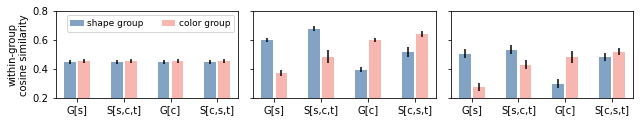

In [58]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=[9,1.8])

for l, layer in enumerate(['input', 'L0', 'L1']):
    for t, task in enumerate(['group[shape]', 'sort[shape]', 'group[color]', 'sort[color]']):
       ax = axes[l]
       axes[l].bar(t-0.15, np.mean(similarities[task][layer]['shape']), yerr=np.std(similarities[task][layer]['shape']), 
              alpha=0.7, color='#4F7CAC', lw=2, width=0.25, label='shape group' if l==0 and t==0 else None)
       axes[l].bar(t+0.15, np.mean(similarities[task][layer]['color']), yerr=np.std(similarities[task][layer]['color']), 
              alpha=0.7, color='#F4978E', lw=2, width=0.25, label='color group' if l==0 and t==0 else None)
    #    axes[l].set_title(layer)

axes[0].set_xticks([0,1,2,3])
_ = axes[0].set_xticklabels(['G[s]', 'S[s,c,t]', 'G[c]', 'S[c,s,t]'])
axes[0].set_ylabel('within-group\ncosine similarity')
axes[0].legend(ncol=2, prop={'size':9}, handlelength=1.5, handletextpad=0.4)
axes[0].set_ylim(0.2, 0.8)

fig.tight_layout()
# fig.savefig('../figure/v1/%s/source_group_sim.pdf'%runid)

SVD

In [11]:
def svd(data):
    data = data - data.mean(0) # center the data
    u, s, v = np.linalg.svd(data, full_matrices=False)
    print('SVD shapes: u.shape=%s, s.shape=%s, v.shape=%s' % (u.shape, s.shape, v.shape))
    return (u, s, v)

In [10]:
# input embeddings - complete
all_items = list(it.product(range(5),range(5),range(5)))
all_items_multihot = torch.stack([torch.cat( (torch.tensor([0]*7), 
                                            F.one_hot(torch.tensor(x).unsqueeze(-1), num_classes=5).view(-1)) ) 
                                for x in all_items])
all_labels = F.pad(F.one_hot(torch.arange(50), 50), pad=(7,0), value=0)

input_embeddings = []
for x in all_items_multihot:
    for l in all_labels:
        embeddings = model.transformer.item_embed(x.float().to(model.device)).detach().cpu().numpy() + \
                     model.transformer.label_embed(l.float().to(model.device)).detach().cpu().numpy()
        input_embeddings.append(embeddings)

input_embeddings = pd.DataFrame(input_embeddings)
input_embeddings['layer'] = 'input'
input_embeddings['shape'] = np.repeat([0,1,2,3,4], 25*50)
input_embeddings['color'] = np.tile(np.repeat([0,1,2,3,4], 5*50), 5)
input_embeddings['texture'] = np.tile(np.repeat([0,1,2,3,4], 50), 25)
input_embeddings['label'] = np.tile(list(range(50)), 125)

In [29]:
# input SVD
df = input_embeddings.copy()

u, s, v = svd(df[range(model.hparams.embed_dim)].values)
u = pd.DataFrame(u)
u = pd.concat([df[['layer', 'shape', 'color', 'texture', 'label']], u], axis=1)
# u.to_csv('../figure/v1/%s/svdpca/source-input-svd-u.csv'%(runid))
# pd.DataFrame(s).to_csv('../figure/v1/%s/svdpca/source-input-svd-s.csv'%(runid))

SVD shapes: u.shape=(6250, 192), s.shape=(192,), v.shape=(192, 192)


Text(0.5, 24.0, '125 items')

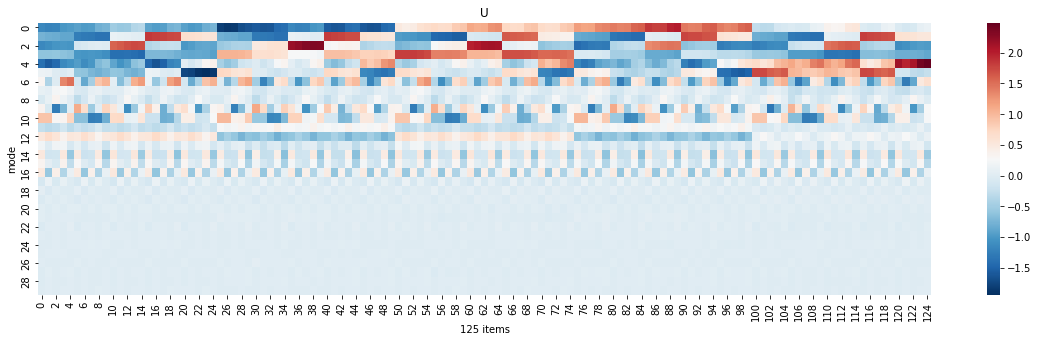

In [14]:
fig, ax = plt.subplots(1, figsize=[20,5])
seaborn.heatmap((u.groupby(['shape', 'color', 'texture']).mean()[range(30)].values * s[:30]).T, ax=ax, cmap='RdBu_r')
ax.set_title('U')
ax.set_ylabel('mode')
ax.set_xlabel('125 items')

In [61]:
# input embeddings - components
binary_tokens = {'shape': F.pad(F.one_hot(torch.arange(5), num_classes=5), pad=(7,10), value=0),
                 'color': F.pad(F.one_hot(torch.arange(5), num_classes=5), pad=(12,5), value=0),
                 'texture': F.pad(F.one_hot(torch.arange(5), num_classes=5), pad=(17,0), value=0),
                 'label': F.pad(F.one_hot(torch.arange(50), 50), pad=(7,0), value=0)}

In [59]:
token = 'shape'
embed_weights = model.transformer.item_embed
embeddings = [embed_weights(x.float().to(model.device)).detach().cpu().numpy() for x in binary_tokens[token]]
embeddings = pd.DataFrame(embeddings)
embeddings['layer'] = 'input'
embeddings[token] = list(range(5))

df = embeddings
u, s, v = svd(df[range(model.hparams.embed_dim)].values.T, n_comp=20)
u = pd.DataFrame(u)
v = pd.DataFrame(v.T)
s

full SVD shapes: u.shape=(192, 5), s.shape=(5,), v.shape=(5, 5)
truncated SVD shapes: u.shape=(192, 5), s.shape=(5,), v.shape=(5, 5)


array([3.5677736, 2.464695 , 2.212784 , 2.0308335, 1.2934976],
      dtype=float32)

Text(0, 0.5, 'mode')

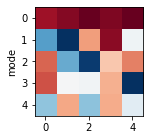

In [60]:
plt.figure(figsize=[2,2])
plt.imshow((v*s).T)
plt.ylabel('mode')

In [42]:
token = 'color'
embed_weights = model.transformer.item_embed
embeddings = [embed_weights(x.float().to(model.device)).detach().cpu().numpy() for x in binary_tokens[token]]
embeddings = pd.DataFrame(embeddings)
embeddings['layer'] = 'input'
embeddings[token] = list(range(5))

df = embeddings
u, s, v = svd(df[range(model.hparams.embed_dim)].values.T, n_comp=20)
u = pd.DataFrame(u)
v = pd.DataFrame(v.T)
s

full SVD shapes: u.shape=(192, 5), s.shape=(5,), v.shape=(5, 5)
truncated SVD shapes: u.shape=(192, 5), s.shape=(5,), v.shape=(5, 5)


array([3.5731091, 2.441933 , 2.304887 , 1.9872445, 1.4448454],
      dtype=float32)

In [50]:
token = 'texture'
embed_weights = model.transformer.item_embed
embeddings = [embed_weights(x.float().to(model.device)).detach().cpu().numpy() for x in binary_tokens[token]]
embeddings = pd.DataFrame(embeddings)
embeddings['layer'] = 'input'
embeddings[token] = list(range(5))

df = embeddings
u, s, v = svd(df[range(model.hparams.embed_dim)].values.T, n_comp=20)
u = pd.DataFrame(u)
v = pd.DataFrame(v.T)
s

full SVD shapes: u.shape=(192, 5), s.shape=(5,), v.shape=(5, 5)
truncated SVD shapes: u.shape=(192, 5), s.shape=(5,), v.shape=(5, 5)


array([3.449747 , 1.7656828, 1.479459 , 1.1275835, 0.9824376],
      dtype=float32)

SVD shapes: u.shape=(50, 50), s.shape=(50,), v.shape=(50, 192)


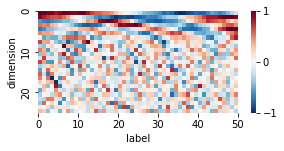

In [43]:
labels = F.pad(F.one_hot(torch.arange(50), 50), pad=(7,0), value=0)
embed_weights = model.transformer.label_embed
embeddings = [embed_weights(x.float().to(model.device)).detach().cpu().numpy() for x in labels]
embeddings = pd.DataFrame(embeddings)
embeddings['layer'] = 'input'
embeddings['label'] = list(range(50))

df = embeddings
u, s, v = svd(df[range(model.hparams.embed_dim)].values)
fig, ax = plt.subplots(1, figsize=[4.2,2.2])

seaborn.heatmap((u*s).T[:25], ax=ax, cmap='RdBu_r', vmin=-1, vmax=1, cbar_kws={'ticks': [-1,0,1]})
ax.set_ylabel('dimension')
ax.set_yticks(range(25)[::10])
_ = ax.set_yticklabels(range(25)[::10])
ax.set_xlabel('label')
ax.set_xticks(range(51)[::10])
_ = ax.set_xticklabels(range(51)[::10], rotation=0)

fig.tight_layout()
# fig.savefig('../figure/v1/%s/svd/input-labelembed-svd-US.pdf'%(runid))

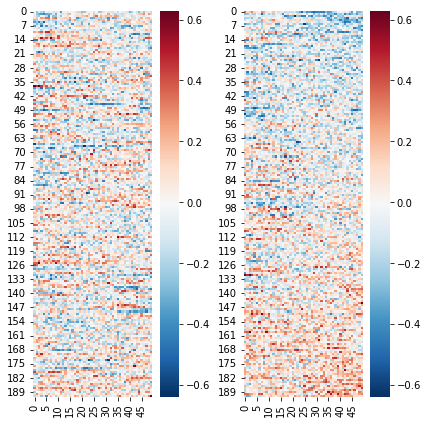

In [104]:
fig, axes = plt.subplots(1, 2, figsize=[6,6])

label_embeddings = model.transformer.label_embed(binary_tokens['label'].float().to(model.device)).detach().cpu() # label_embeddings.shape (50, 192)
sort_idx = torch.matmul(label_embeddings.T, torch.arange(50).float()).argsort()

# seaborn.heatmap(label_embeddings.T, ax=axes[0], cbar=None, cmap='RdBu_r', vmin=-0.32, vmax=0.32)
seaborn.heatmap(label_embeddings.T, ax=axes[0], cmap='RdBu_r')
seaborn.heatmap(label_embeddings.T[sort_idx], ax=axes[1], cmap='RdBu_r')

fig.tight_layout()

<AxesSubplot:>

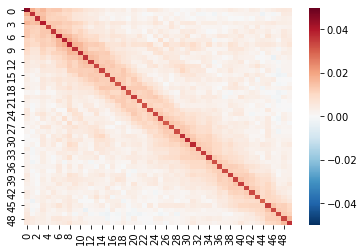

In [35]:
seaborn.heatmap(np.cov(embeddings[range(192)]), cmap='RdBu_r', vmin=-0.05, vmax=0.05)

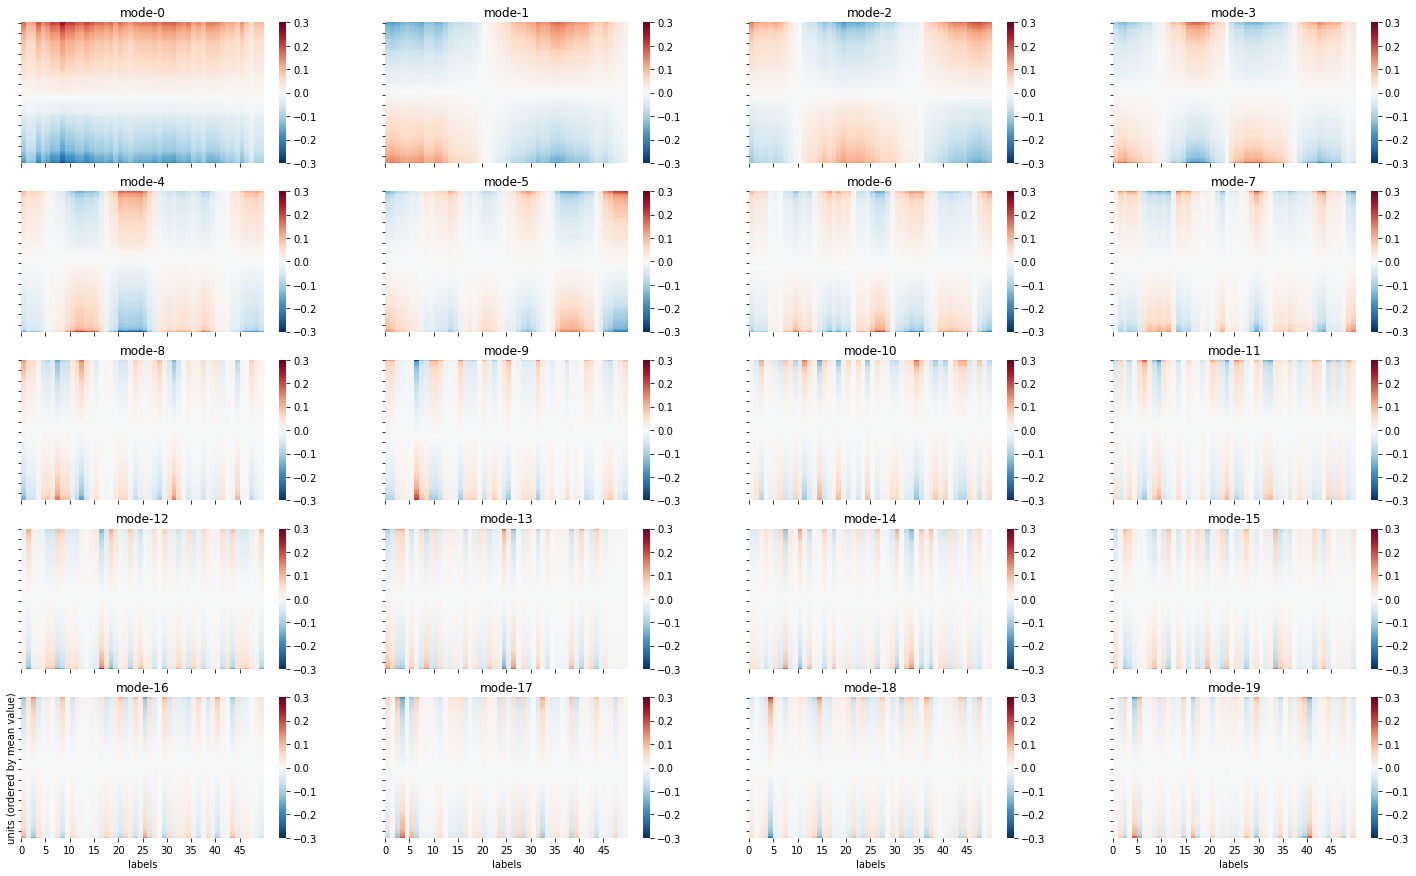

In [24]:
mode0_units_sort_idx = np.argsort(np.outer(u[0], v[0]).mean(1))[::-1]
unit_labels = np.array([str(i) for i in range(model.hparams.embed_dim)])
original_unit_labels = np.array([unit_labels[mode0_units_sort_idx.tolist().index(i)] for i in range(model.hparams.embed_dim)])

fig, axes = plt.subplots(5, 4, figsize=[25,15], sharex=True)

for mode in range(20):
    ax = axes[int(mode/4), mode%4]
    ax.set_title('mode-%d'%mode)

    outer_prod = np.outer(u[mode].values, v[mode].values)
    units_sort_idx = np.argsort(outer_prod.mean(1))[::-1] # sort units by mean Vh value from high to low
    seaborn.heatmap(outer_prod[units_sort_idx]*s[mode], ax=ax, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
    ax.tick_params(axis='y', which='both', labelleft=False)

    if mode == 16:
        ax.set_ylabel('units (ordered by mean value)')
    
    if int(mode/4) == 4:
        ax.set_xticks(range(50)[::5])
        ax.set_xticklabels(range(50)[::5])
        ax.set_xlabel('labels')
    
# fig.savefig('../figure/v1/%s/svd/input-labelembed-svd-outer-prod.pdf'%(runid))

In [57]:
# L0 SVD
df = embedding_df.copy()
df.replace(to_replace={'task': 'sort_by_shape'}, value='group[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_shape_first'}, value='sort[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color'}, value='group[color]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color_first'}, value='sort[color]', inplace=True)
df['task'] = pd.Categorical(df['task'], ['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]'])
df = df[np.in1d(df['source_probe_target'], ['source','probe'])&(df['layer']=='L0')&(df['item_type']=='item')].reset_index()

u, s, v = svd(df[range(model.hparams.embed_dim)].values)
u = pd.DataFrame(u)
u = pd.concat([df[['layer', 'source_probe_target','task', 'shape', 'color', 'texture', 'label']], u], axis=1)
u.to_csv('../figure/v1/%s/svdpca/spjoint-L0-svd-u.csv'%(runid))
pd.DataFrame(s).to_csv('../figure/v1/%s/svdpca/spjoint-L0-svd-s.csv'%(runid))

SVD shapes: u.shape=(72000, 192), s.shape=(192,), v.shape=(192, 192)


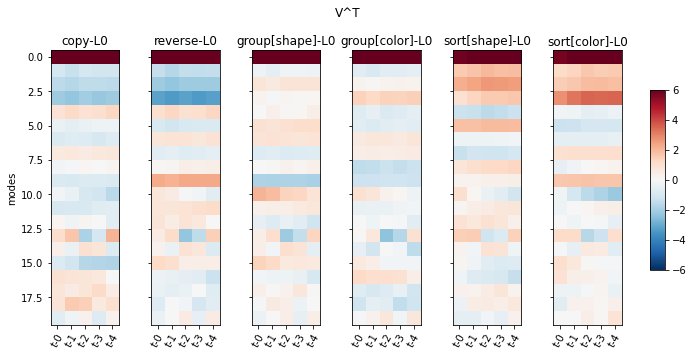

In [ ]:
fig = plot_v_obs(v.groupby(['layer', 'task', 'texture']).mean().reset_index(), n_comp=n_comp, 
                 row_key='layer', row_vals=['L0'],
                 col_key='task', col_vals=['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]'], 
                 figsize=[10,5], vmin=-6, vmax=6, 
                 xticks=range(5), xticklabels=['t-%d'%x for x in range(5)])
# fig.savefig('../figure/v1/%s/svd/spjoint-L0-svd-v-shape.pdf'%(runid))

In [122]:
# probe/target coexistence in L1
df = embedding_df.copy()
df.replace(to_replace={'task': 'sort_by_shape'}, value='group[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_shape_first'}, value='sort[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color'}, value='group[color]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color_first'}, value='sort[color]', inplace=True)
df['task'] = pd.Categorical(df['task'], ['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]'])

df = df[np.in1d(df['source_probe_target'], ['probe','target'])&(df['layer']=='L1')&(df['item_type']=='item')].reset_index()

u, s, v = svd(df[range(model.hparams.embed_dim)].values.T, n_comp=192)
u = pd.DataFrame(u)
v = pd.DataFrame(v.T)
v = pd.concat([df[['source_probe_target','task', 'shape', 'color', 'texture', 'label']], v], axis=1)
v['layer'] = 'L1'
# v.to_csv('../figure/v1/%s/svd/ptjoint-L1-svd-v.csv'%(runid))
# pd.DataFrame(s).to_csv('../figure/v1/%s/svd/ptjoint-L1-svd-s.csv'%(runid))

full SVD shapes: u.shape=(192, 192), s.shape=(192,), v.shape=(192, 72000)
truncated SVD shapes: u.shape=(192, 192), s.shape=(192,), v.shape=(192, 72000)


In [123]:
# probe/target coexistence in L1
df = embedding_df.copy()
df.replace(to_replace={'task': 'sort_by_shape'}, value='group[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_shape_first'}, value='sort[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color'}, value='group[color]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color_first'}, value='sort[color]', inplace=True)
df['task'] = pd.Categorical(df['task'], ['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]'])

boundary_items = ( (df['source_probe_target']=='probe')&(df['boundary']=='end')&(df['out_pos']!=29) ) | \
                 ( (df['source_probe_target']=='target')&(df['boundary']=='begin')&(df['out_pos']!=0) )
df = df[np.in1d(df['source_probe_target'], ['probe','target'])&(df['layer']=='L1')&(df['item_type']=='item')&boundary_items].reset_index()

u, s, v = svd(df[range(model.hparams.embed_dim)].values.T, n_comp=192)
u = pd.DataFrame(u)
v = pd.DataFrame(v.T)
v = pd.concat([df[['source_probe_target','task', 'shape', 'color', 'texture', 'label']], v], axis=1)
v['layer'] = 'L1'
# v.to_csv('../figure/v1/%s/svd/ptjoint-L1-svd-v-boundary.csv'%(runid))
# pd.DataFrame(s).to_csv('../figure/v1/%s/svd/ptjoint-L1-svd-s-boundary.csv'%(runid))

full SVD shapes: u.shape=(192, 192), s.shape=(192,), v.shape=(192, 6382)
truncated SVD shapes: u.shape=(192, 192), s.shape=(192,), v.shape=(192, 6382)


In [14]:
# create two-item batches
fake_batch = {}
N = 2000
tasks = np.tile(['copy', 'reverse', 'sort_by_shape', 'sort_by_shape_first', 'sort_by_color', 'sort_by_color_first'], N)

seqs = []
outseqs = []
random_labels = []
sorted_labels = []
sort_indices = []
short_eos = torch.tensor([0,0,0,0,0,0,1]+[0]*15).unsqueeze(0)
long_eos = torch.tensor([0,0,0,0,0,0,1]+[0]*50).unsqueeze(0)

for i in range(N):
    # randomly sample two items
    item_ind = np.random.choice(np.arange(125), size=2, replace=False)
    items = all_items_multihot[item_ind]
    features = items[:, 7:].reshape((2,3,5)).argmax(-1) # (2, 3)
    # randomly sample two labels (sorted)
    label_ind = np.sort(np.random.choice(np.arange(50), size=2, replace=False))
    labels = all_labels[label_ind]

    for t, task in enumerate(tasks[:6]):
        # generate sort_idx
        if task == 'copy':
            sort_idx = list(range(len(items)))
        elif task == 'reverse':
            sort_idx = list(reversed(range(len(items))))
        elif task == 'sort_by_shape':
            sort_idx = features[:, 0].argsort()
        elif task == 'sort_by_shape_first':
            # lazy hack, not generalizable to more than two items
            sort_idx = features[:, 0].argsort() if features[0,0] != features[1,0] \
                       else features[:, 1].argsort() if features[0,1] != features[1,1] else features[:, 2].argsort()
        elif task == 'sort_by_color':
            sort_idx = features[:, 1].argsort()
        elif task == 'sort_by_color_first':
            sort_idx = features[:, 1].argsort() if features[0,1] != features[1,1] \
                       else features[:, 0].argsort() if features[0,0] != features[1,0] else features[:, 2].argsort()

        # then append everything
        short_task_token = torch.cat((F.one_hot(torch.tensor(t), num_classes=7), torch.zeros(15))).unsqueeze(0)
        long_task_token = torch.cat((F.one_hot(torch.tensor(t), num_classes=7), torch.zeros(50))).unsqueeze(0)
        seqs.append( torch.cat((short_task_token, items.clone(), short_eos)) )
        random_labels.append( torch.cat((long_task_token, labels.clone(), long_eos)) )
        outseqs.append( torch.cat((short_task_token, items.clone()[sort_idx], short_eos)) )
        sorted_labels.append( torch.cat((long_task_token, labels.clone()[sort_idx], long_eos)) )
        sort_indices.append( torch.cat((long_task_token, all_labels[sort_idx].clone(), long_eos)) )

fake_batch['seq'] = torch.stack(seqs).clone()
fake_batch['out_seq'] = torch.stack(outseqs).clone()
fake_batch['random_label'] = torch.stack(random_labels).clone()
fake_batch['sorted_label'] = torch.stack(sorted_labels).clone()
fake_batch['sort_idx'] = torch.stack(sort_indices).clone()
fake_batch = utils.batch_to_device(fake_batch, model.device, except_keys=[])

In [15]:
with torch.no_grad():
    result_dict = model.forward(fake_batch)
    loss_dict, acc_dict = model._calc_loss_acc(result_dict)
loss_dict, acc_dict

({'task_loss': tensor(0.0002, device='cuda:4'),
  'item_loss': tensor(0.3029, device='cuda:4'),
  'label_loss': tensor(0.5334, device='cuda:4')},
 {'task_acc': tensor(1., device='cuda:4'),
  'item_acc': tensor(0.9353, device='cuda:4'),
  'label_acc': tensor(0.9096, device='cuda:4'),
  'task0_task_acc': tensor(1., device='cuda:4'),
  'task0_item_acc': tensor(0.9925, device='cuda:4'),
  'task0_label_acc': tensor(0.9908, device='cuda:4'),
  'task1_task_acc': tensor(1., device='cuda:4'),
  'task1_item_acc': tensor(0.9811, device='cuda:4'),
  'task1_label_acc': tensor(0.9818, device='cuda:4'),
  'task2_task_acc': tensor(1., device='cuda:4'),
  'task2_item_acc': tensor(0.8949, device='cuda:4'),
  'task2_label_acc': tensor(0.8425, device='cuda:4'),
  'task3_task_acc': tensor(1., device='cuda:4'),
  'task3_item_acc': tensor(0.8940, device='cuda:4'),
  'task3_label_acc': tensor(0.8403, device='cuda:4'),
  'task4_task_acc': tensor(1., device='cuda:4'),
  'task4_item_acc': tensor(0.9274, device='

In [16]:
encoded_reps = model.get_encoded_reps(fake_batch, batch_processed=False, teacher_forcing=True)
print(encoded_reps['input_embed'].shape)
print(encoded_reps['attn_embed'].shape)
embedding_df = embedding_matrix_to_dataframe(tasks, model, fake_batch, encoded_reps)

torch.Size([12000, 8, 192])
torch.Size([2, 12000, 8, 192])


In [41]:
df = embedding_df.copy()
df.replace(to_replace={'task': 'sort_by_shape'}, value='group[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_shape_first'}, value='sort[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color'}, value='group[color]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color_first'}, value='sort[color]', inplace=True)
df['task'] = pd.Categorical(df['task'], ['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]'])

# select the same representations
df_probe = df[(df['layer']=='L1')&(df['source_probe_target'].values=='probe')&(df['out_pos'].values==0)].reset_index()

In [42]:
df_probe['task'].unique()

['copy', 'reverse', 'group[shape]', 'sort[shape]', 'group[color]', 'sort[color]']
Categories (6, object): ['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]']

In [71]:
df = embedding_df.copy()
df.replace(to_replace={'task': 'sort_by_shape'}, value='group[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_shape_first'}, value='sort[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color'}, value='group[color]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color_first'}, value='sort[color]', inplace=True)
df['task'] = pd.Categorical(df['task'], ['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]'])

# select the same representations
df_probe = df[(df['layer']=='L1')&(df['source_probe_target'].values=='probe')&(df['out_pos'].values==0)].reset_index()
# equivalent with ((df['source_probe_target'].values=='target') & (df['out_pos'].values==1))

u, s, v = svd(df_probe[range(model.hparams.embed_dim)].values)
u = pd.DataFrame(u)

# create copies with probe-view and target-view
u_probe = pd.concat([df_probe[['layer', 'source_probe_target','task', 'shape', 'color', 'texture', 'label']], u], axis=1)
df_target = df[(df['layer']=='L1')&(df['source_probe_target'].values=='target')&(df['out_pos'].values==1)].reset_index()
u_target = pd.concat([df_target[['layer', 'source_probe_target','task', 'shape', 'color', 'texture', 'label']], u.copy()], axis=1)
u = pd.concat([u_probe, u_target]).reset_index()

u.to_csv('../figure/v1/%s/svdpca/ptjoint-L1-svd-u-seqlen=2.csv'%(runid))
pd.DataFrame(s).to_csv('../figure/v1/%s/svdpca/ptjoint-L1-svd-s-seqlen=2.csv'%(runid))

SVD shapes: u.shape=(2000, 192), s.shape=(192,), v.shape=(192, 192)
SVD shapes: u.shape=(2000, 192), s.shape=(192,), v.shape=(192, 192)
SVD shapes: u.shape=(2000, 192), s.shape=(192,), v.shape=(192, 192)
SVD shapes: u.shape=(2000, 192), s.shape=(192,), v.shape=(192, 192)
SVD shapes: u.shape=(2000, 192), s.shape=(192,), v.shape=(192, 192)
SVD shapes: u.shape=(2000, 192), s.shape=(192,), v.shape=(192, 192)


In [51]:
runid

'3cyk4n4w'

PCA

In [ ]:
def plot_points(ax, df_plot, shapes, colors, edge_colors, marker_size, 
                hide_ticks=False, dim=3, axval=None, rotate=(30, 300)):

    if dim == 3:
        ax.view_init(*rotate)

    for index, row in df_plot.iterrows():
        if dim == 2:
            ax.scatter(row['PC1'], row['PC2'], marker=shapes[index], color=colors[index], edgecolor=edge_colors[index], s=marker_size, alpha=0.6)
        else:
            ax.scatter(row['PC1'], row['PC2'], row['PC3'], marker=shapes[index], color=colors[index], edgecolor=edge_colors[index], s=marker_size, alpha=0.6)
    if axval is not None:
        ax.set_xlim(-axval, axval)
        ax.set_ylim(-axval, axval)

    if dim == 2:
        if hide_ticks:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
        else:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
    
    if dim == 3:
        if axval is not None:
            ax.set_zlim(-axval, axval)
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        if hide_ticks:
            ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
            ax.tick_params(axis='z', which='both', left=False, labelleft=False)
        else:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
            # ax.set_zlabel('PC3')

def reduce_dim(df, dr_spec, verbose=False):

    def calc_pca(df):
        pca = sklearn.decomposition.PCA(n_components=dr_spec['n_comp'])
        lowdim_embed = pca.fit_transform(df[range(model.hparams.embed_dim)].values)
        if verbose: print('var explained:', pca.explained_variance_ratio_[:3])
        # tsne = sklearn.manifold.TSNE(n_components=dr_spec['n_comp'], perplexity=dr_spec['pp'], n_iter=dr_spec['iter'])
        # lowdim_embed = tsne.fit_transform(df[range(model.hparams.embed_dim)].values)
        # if verbose: print('kl div:', tsne.kl_divergence_)
        df['PC1'] = lowdim_embed[:,0]
        df['PC2'] = lowdim_embed[:,1]
        df['PC3'] = lowdim_embed[:,2]
        return df

    result = {}

    for layer in ['input', 'L0', 'L1']:

        # do a joint source/probe pca
        subdf = df[(df['layer']==layer)&(df['item_type']=='item')&np.in1d(df['source_probe_target'], ['source', 'probe'])]
        subdf = subdf.groupby(['shape', 'color', 'texture', 'task']).mean().reset_index()
        if verbose: print('%s - %s: ' % (layer, 'spjoint'), end='  |')
        subdf = calc_pca(subdf)
        result['%s-spjoint'%layer] = subdf
        
        for sqtype in ['source', 'probe', 'target']:
            subdf = df[(df['layer']==layer)&(df['item_type']=='item')&(df['source_probe_target']==sqtype)]
            subdf = subdf.groupby(['shape', 'color', 'texture', 'task']).mean().reset_index()
            if verbose: print('%s - %s: ' % (layer, sqtype), end='  |')
            subdf = calc_pca(subdf)
            result['%s-%s'%(layer, sqtype)] = subdf
    
    return result

def visualize_lowdim_embedding(df, figsize, dim, axval, edge_colors, **kwargs):

    def int_to_shape(s):
        return ['o', '^', 's', 'p', 'X'][s]

    def int_to_color(c):
        return ['#ff8c69','#ff6996','#de69ff','#697dff','#69daff'][c]

    def int_to_texture(t, c):
        dark_colors = ['#a35943', '#a3415f', '#8b3fa1', '#424fa1', '#4289a1']
        return utils.discrete_color_gradient('#ffffff', dark_colors[c], 5)[t]
    
    fig = plt.figure(figsize=figsize)
    task_display_names = {'copy':'copy', 'reverse':'reverse', 
                          'sort_by_shape':'group [shape]', 'sort_by_color':'group [color]',
                          'sort_by_shape_first':'sort [shape]', 'sort_by_color_first':'sort [color]'}
    
    # visuzlize
    for t, task in enumerate(task_display_names.keys()):
        ax = fig.add_subplot(1, 6, t+1) if dim==2 else fig.add_subplot(1, 6, t+1, projection='3d')
        ax.set_title(task_display_names[task])
    
        df_plot = df[(df['task']==task)].reset_index()
        shapes = [int_to_shape(s) for s in df_plot['shape'].values]
        colors = [int_to_color(c) for c in df_plot['color'].values]
        edge_colors = colors if not edge_colors else [int_to_texture(t, c=df_plot['color'].values[i]) for i, t in enumerate(df_plot['texture'].values)]
        plot_points(ax, df_plot, shapes, colors, edge_colors, dim=dim, axval=axval, **kwargs)

    fig.tight_layout()
    if dim==3: plt.subplots_adjust(wspace=-0.1)
    return fig

In [ ]:
dr_spec = {'method': 'pca', 'n_comp': 3}
lowdim_embeddings = reduce_dim(embedding_df, dr_spec=dr_spec, verbose=True)

input - spjoint:   |var explained: [0.1701865 0.1491737 0.1473114]
input - source:   |var explained: [0.17018612 0.14917366 0.14731142]
input - probe:   |var explained: [0.17018618 0.14917396 0.14731145]
input - target:   |var explained: [0.220285   0.18572283 0.16848782]
L0 - spjoint:   |var explained: [0.1239024  0.11856829 0.11055881]
L0 - source:   |var explained: [0.12403402 0.11865763 0.11419867]
L0 - probe:   |var explained: [0.11830253 0.11321907 0.1036024 ]
L0 - target:   |var explained: [0.1561944  0.13173823 0.12079844]
L1 - spjoint:   |var explained: [0.1313642  0.10515527 0.09506319]
L1 - source:   |var explained: [0.12454256 0.11000803 0.09310365]
L1 - probe:   |var explained: [0.14925477 0.09706386 0.08019575]
L1 - target:   |var explained: [0.10117994 0.0957681  0.0860965 ]


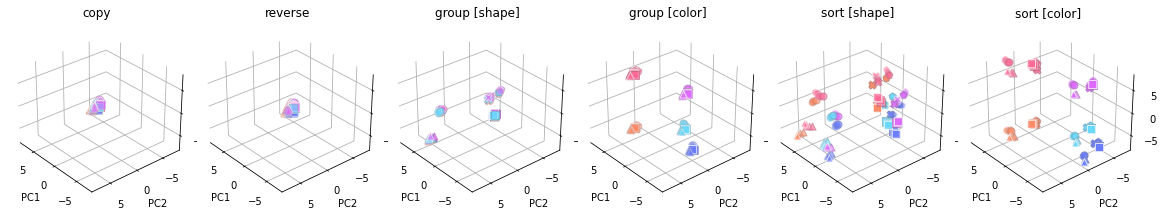

In [ ]:
fig = visualize_lowdim_embedding(df=lowdim_embeddings['L0-spjoint'], figsize=[16,3.2], dim=3,
                                 axval=8, edge_colors=True, rotate=(30,140), marker_size=50, hide_ticks=False)
fig.tight_layout()

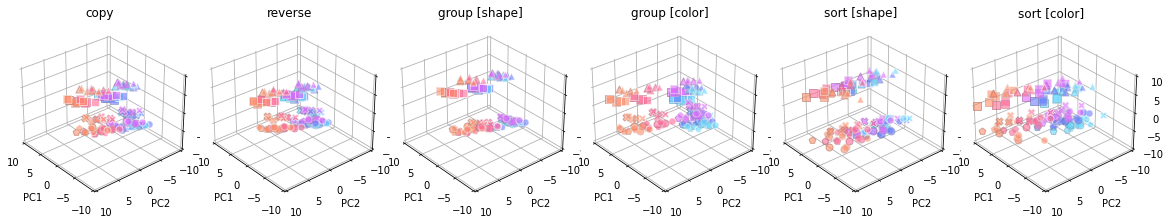

In [ ]:
fig = visualize_lowdim_embedding(df=lowdim_embeddings['L1-target'], figsize=[16,3.2], dim=3,
                                 axval=10, edge_colors=True, rotate=(30,140), marker_size=50, hide_ticks=False)
fig.tight_layout()
# fig.savefig('../figure/v1/%s/L1-target-feature-pca.pdf'%(runid))

In [ ]:
# 3d plot rotation
for layer, sqtype in it.product(['input', 'L0', 'L1'], ['spjoint', 'source', 'probe', 'target']):
    print(layer, sqtype)
    if layer == 'input':
        axval = 2
    elif layer == 'L0':
        axval = 8
    else:
        axval = 10
    if not os.path.exists('../figure/v1/%s/rotate/%s_%s_pca/'%(runid, sqtype, layer)):
        os.mkdir('../figure/v1/%s/rotate/%s_%s_pca/'%(runid, sqtype, layer))
    for angle in range(0,360,10):
        fig = visualize_lowdim_embedding(df=lowdim_embeddings['%s-%s'%(layer, sqtype)], figsize=[22,5], dim=3,
                                        axval=axval, edge_colors=True, rotate=(30,angle), marker_size=140, hide_ticks=True)
        fig.savefig('../figure/v1/%s/rotate/%s_%s_pca/%03d.pdf'%(runid, sqtype, layer, angle))
        plt.close()

input spjoint
input source
input probe
input target
L0 spjoint
L0 source
L0 probe
L0 target
L1 spjoint
L1 source
L1 probe
L1 target


In [ ]:
# how probe and target shares the representation space in L1

# do a joint probe/target pca for L1
df = embedding_df
subdf = df[(df['layer']=='L1')&(df['item_type']=='item')&np.in1d(df['source_probe_target'], ['probe', 'target'])]
subdf = subdf.groupby(['shape', 'color', 'texture', 'task', 'source_probe_target']).mean().reset_index()
pca = sklearn.decomposition.PCA(n_components=3)
lowdim_embed = pca.fit_transform(subdf[range(model.hparams.embed_dim)].values)
subdf['PC1'] = lowdim_embed[:,0]
subdf['PC2'] = lowdim_embed[:,1]
subdf['PC3'] = lowdim_embed[:,2]

In [ ]:
dim = 3
fig = plt.figure(figsize=[22,5])
task_display_names = {'copy':'copy', 'reverse':'reverse', 
                        'sort_by_shape':'group [shape]', 'sort_by_color':'group [color]',
                        'sort_by_shape_first':'sort [shape]', 'sort_by_color_first':'sort [color]'}
for angle in range(0,360,10):
    for t, task in enumerate(task_display_names.keys()):
        ax = fig.add_subplot(1, 6, t+1) if dim==2 else fig.add_subplot(1, 6, t+1, projection='3d')
        ax.set_title(task_display_names[task])

        df_plot = subdf[(subdf['task']==task)].reset_index()
        shapes = ['o'] * len(df_plot)
        colors = ['C0' if x == 'probe' else 'C1' for x in df_plot['source_probe_target'].values]
        edge_colors = colors
        plot_points(ax, df_plot, shapes, colors, edge_colors, dim=dim, axval=None, rotate=(30,angle), marker_size=140, hide_ticks=True)

    fig.tight_layout()
    if dim==3: plt.subplots_adjust(wspace=-0.1)
    fig.savefig('../figure/v1/%s/rotate/ptjoint_L1_pca_avgfirst/%03d.pdf'%(runid, angle))
    plt.close()

decoding representations

In [ ]:
# preparing the dataset for decoding
hold_val_seq = 150
df = embedding_df[embedding_df['item_type']=='item']
df['itemnum'] = df['shape'].values*25 + df['color'].values*5 + df['texture'].values
# adjust task names
df.replace(to_replace={'task': 'sort_by_shape'}, value='group[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_shape_first'}, value='sort[shape]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color'}, value='group[color]', inplace=True)
df.replace(to_replace={'task': 'sort_by_color_first'}, value='sort[color]', inplace=True)
sqtypes = ['source', 'probe', 'target']
layers = ['input', 'L0', 'L1']
tasks = ['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]']
features = ['shape', 'color', 'texture']

In [ ]:
# averaging across items that precede the target item induces higher decoding accuracy of target features in early layers
accs = defaultdict(list)
for layer in ['input','L0','L1']:
    subdf = df[(df['layer']==layer)&(df['item_type']=='item')&(df['source_probe_target']=='target')]

    for task in tasks:
        train_df = subdf[(subdf['task']==task)&(subdf['seq']<hold_val_seq)].groupby(['shape', 'color', 'texture']).mean().reset_index()
        val_df = subdf[(subdf['task']==task)&(subdf['seq']>=hold_val_seq)].groupby(['shape', 'color', 'texture']).mean().reset_index()

        for feature in ['shape', 'color', 'texture']:
            decoder = sklearn.linear_model.LogisticRegression(C=1)
            decoder.fit(train_df[range(model.hparams.embed_dim)], train_df[feature])

            accs['layer'].append(layer)
            accs['task'].append(task)
            accs['feature'].append(feature)
            accs['train-acc'].append(decoder.score(train_df[range(model.hparams.embed_dim)], train_df[feature]))
            accs['val-acc'].append(decoder.score(val_df[range(model.hparams.embed_dim)], val_df[feature]))
accs = pd.DataFrame(accs)

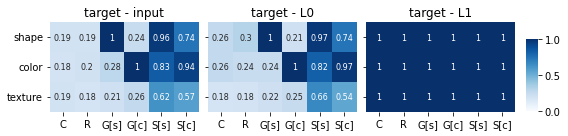

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=[8,2], sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.5])

for i, layer in enumerate(['input', 'L0', 'L1']):
    ax = axes[i]
    ax.set_title('target - %s' % (layer))

    vals = accs[(accs['layer']==layer)]
    im = seaborn.heatmap(ax=ax, data=vals['val-acc'].values.reshape((6,3)).T, vmin=0, vmax=1, 
                         annot=True, annot_kws={'fontsize':8}, cmap='Blues', cbar=i==0, cbar_ax=cbar_ax if (i==0) else None)
    ax.set_yticklabels(['shape', 'color', 'texture'], rotation=0)
    ax.set_xticklabels(['C', 'R', 'G[s]', 'G[c]', 'S[s]', 'S[c]'])

fig.tight_layout()
fig.subplots_adjust(right=0.90)

In [ ]:
acc_df = {
    'source_probe_target': [],
    'layer': [],
    'task': [],
    'feature': [],
    'train_acc': [],
    'val_acc': []
}
for (sqtype, layer, task, feature) in it.product(sqtypes, layers, tasks, features): 
    acc_df['transfer-acc-%s-%s-%s-%s'%(sqtype, layer, task, feature)] = []

In [ ]:
# take the individual vectors at each task x layer < hold_val_seq
# train decoders to extract shape, color, and texture information
for (sqtype, layer, task, feature) in it.product(sqtypes, layers, tasks, features):

    acc_df['source_probe_target'].append(sqtype)
    acc_df['layer'].append(layer)
    acc_df['task'].append(task)
    acc_df['feature'].append(feature)

    train_X = df[(df['source_probe_target']==sqtype)&(df['layer']==layer)&(df['task']==task)&(df['seq']<hold_val_seq)][range(model.hparams.embed_dim)]
    train_y = df[(df['source_probe_target']==sqtype)&(df['layer']==layer)&(df['task']==task)&(df['seq']<hold_val_seq)][feature]
    decoder = sklearn.linear_model.LogisticRegression(C=1)
    decoder.fit(train_X, train_y)
    acc_df['train_acc'].append(decoder.score(train_X, train_y)) # train acc

    # validate on the remaining vectors within this task x layer >= hold_val_seq
    val_X = df[(df['source_probe_target']==sqtype)&(df['layer']==layer)&(df['task']==task)&(df['seq']>=hold_val_seq)][range(model.hparams.embed_dim)]
    val_y = df[(df['source_probe_target']==sqtype)&(df['layer']==layer)&(df['task']==task)&(df['seq']>=hold_val_seq)][feature]
    acc_df['val_acc'].append(decoder.score(val_X, val_y)) # val acc

    # check transfer to vectors in all other task x layer x feature triplets
    for (spt, l, t, f) in it.product(sqtypes, layers, tasks, features):
        if sqtype==spt and layer==l and task==t and feature==f:
            acc_df['transfer-acc-%s-%s-%s-%s'%(spt, l, t, f)].append(decoder.score(val_X, val_y)) # val acc
        else:
            X = df[(df['source_probe_target']==spt)&(df['layer']==l)&(df['task']==t)][range(model.hparams.embed_dim)]
            y = df[(df['source_probe_target']==spt)&(df['layer']==l)&(df['task']==t)][f]
            acc_df['transfer-acc-%s-%s-%s-%s'%(spt, l, t, f)].append(decoder.score(X, y)) # transfer acc

In [ ]:
acc_df = pd.DataFrame(acc_df)
pkl.dump(acc_df, open('six_task_decoding_acc_%s.pkl'%(runid), 'wb'))

In [ ]:
acc_df = pkl.load(open('six_task_decoding_acc_%s.pkl'%(runid), 'rb'))

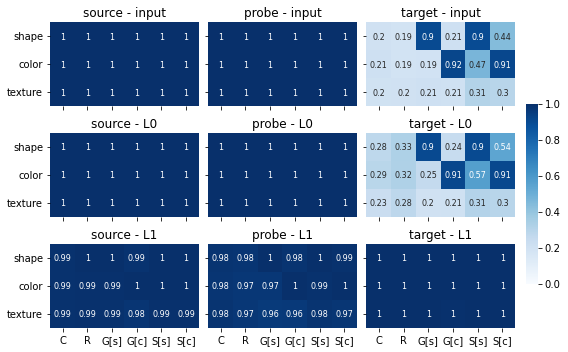

In [ ]:
# decodability of features

fig, axes = plt.subplots(3, 3, figsize=[8,5], sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.5])

for i, sqtype in enumerate(['source', 'probe', 'target']):
    for j, layer in enumerate(['input', 'L0', 'L1']):
        ax = axes[j, i]
        ax.set_title('%s - %s' % (sqtype, layer))

        vals = acc_df[(acc_df['source_probe_target']==sqtype)&(acc_df['layer']==layer)]
        im = seaborn.heatmap(ax=ax, data=vals['val_acc'].values.reshape((6,3)).T, vmin=0, vmax=1, 
                             annot=True, annot_kws={'fontsize':8}, cmap='Blues', cbar=i==j==0, cbar_ax=cbar_ax if (i==j==0) else None)
        ax.set_yticklabels(['shape', 'color', 'texture'], rotation=0)
        ax.set_xticklabels(['C', 'R', 'G[s]', 'G[c]', 'S[s]', 'S[c]'])

fig.tight_layout()
fig.subplots_adjust(right=0.90)

# fig.savefig('../figure/v1/%s/decoding/val_acc.pdf'%(runid))

In [ ]:
acc_df[(acc_df['source_probe_target']=='target')&(acc_df['layer']=='input')&(acc_df['feature']=='shape')]

,source_probe_target,layer,task,feature,train_acc,val_acc,transfer-acc-source-input-copy-shape,transfer-acc-source-input-copy-color,transfer-acc-source-input-copy-texture,transfer-acc-source-input-reverse-shape,...,transfer-acc-target-L1-group[shape]-texture,transfer-acc-target-L1-group[color]-shape,transfer-acc-target-L1-group[color]-color,transfer-acc-target-L1-group[color]-texture,transfer-acc-target-L1-sort[shape]-shape,transfer-acc-target-L1-sort[shape]-color,transfer-acc-target-L1-sort[shape]-texture,transfer-acc-target-L1-sort[color]-shape,transfer-acc-target-L1-sort[color]-color,transfer-acc-target-L1-sort[color]-texture
108,target,input,copy,shape,0.276667,0.201333,0.176000,0.186500,0.174333,0.176000,...,0.137500,0.252667,0.250833,0.136833,0.307167,0.255667,0.108833,0.292000,0.257333,0.111667
111,target,input,reverse,shape,0.270667,0.191333,0.173000,0.178833,0.221833,0.173000,...,0.229333,0.210833,0.165333,0.244333,0.181667,0.226000,0.226833,0.186667,0.199667,0.204333
114,target,input,group[shape],shape,0.919111,0.900667,0.905833,0.198833,0.190833,0.905833,...,0.231833,0.142000,0.180667,0.237167,0.397167,0.179333,0.259833,0.188667,0.195667,0.248500
117,target,input,group[color],shape,0.268889,0.210000,0.064333,0.193500,0.200167,0.064333,...,0.181000,0.221667,0.274500,0.169667,0.188833,0.242500,0.124500,0.195333,0.296333,0.136167
120,target,input,sort[shape],shape,0.936222,0.897333,0.884500,0.228500,0.204000,0.884500,...,0.208667,0.164667,0.196500,0.216667,0.420000,0.173667,0.204833,0.203833,0.190167,0.241000
123,target,input,sort[color],shape,0.513556,0.438000,0.347500,0.242000,0.195833,0.347500,...,0.216000,0.211500,0.300000,0.219000,0.457333,0.237167,0.214000,0.267000,0.272167,0.205833


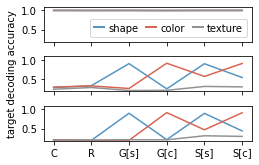

In [ ]:
# decodability of target features

fig, axes = plt.subplots(3, 1, figsize=[3.7,2.4], sharex=True, sharey=True)

colors = ['#5595C2', '#D86551', '#929292']
for l, layer in enumerate(['L1', 'L0', 'input']):
    for f, feature in enumerate(['shape', 'color', 'texture']):
        vals = acc_df[(acc_df['source_probe_target']=='target')&(acc_df['layer']==layer)&(acc_df['feature']==feature)]['val_acc'].values
        axes[l].plot(vals, color=colors[f])

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color, lw=2) for color in colors]
axes[0].legend(custom_lines, ['shape', 'color', 'texture'], loc='lower right', ncol=3, columnspacing=0.8, handlelength=1, handletextpad=0.4)

axes[0].set_ylim((0.18, 1.1))
axes[1].set_ylabel('target decoding accuracy')
axes[-1].set_xticks(range(6))
axes[-1].set_xticklabels(['C', 'R', 'G[s]', 'G[c]', 'S[s]', 'S[c]'])
fig.tight_layout()

# fig.savefig('../figure/v1/%s/decoding/target_val_acc.pdf'%(runid))

In [ ]:
# no decoding transfer between input embedding and output decoding
for feature in ['shape', 'color', 'texture']:
    print(acc_df[(acc_df['source_probe_target']=='source')&(acc_df['layer']=='input')&(acc_df['task']=='copy')&(acc_df['feature']==feature)]\
          ['transfer-acc-target-L1-copy-shape'].values)

[0.14016667]
[0.17983333]
[0.1995]


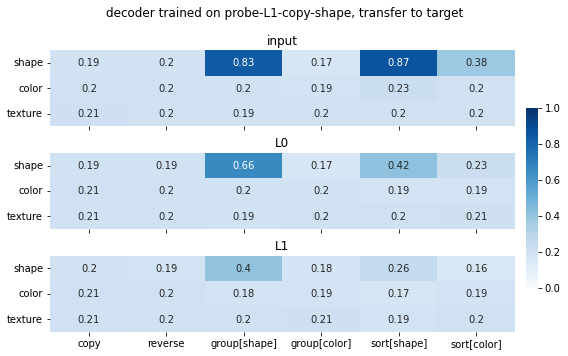

In [ ]:
# decoding transfer

sqtype = 'probe'
transfer_sqtype = 'target'
layer = 'L1'
task = 'copy'
feature = 'shape'

transfer_accs = acc_df[(acc_df['source_probe_target']==sqtype)&(acc_df['layer']==layer)\
                      &(acc_df['task']==task)&(acc_df['feature']==feature)].filter(regex='transfer-acc-%s.*'%transfer_sqtype)

fig, axes = plt.subplots(3, 1, figsize=[8,5], sharex=True)
fig.suptitle('decoder trained on %s-%s-%s-%s, transfer to %s'%(sqtype, layer, task, feature, transfer_sqtype))
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.5])

for i, l in enumerate(['input', 'L0', 'L1']):
    ax = axes[i]
    ax.set_title(l)
    im = seaborn.heatmap(ax=ax, data=transfer_accs.filter(regex='.*%s.*'%l).values.reshape((6,3)).T, 
                         vmin=0, vmax=1, annot=True, cmap='Blues', cbar=i==2, cbar_ax=None if i < 2 else cbar_ax)
    ax.set_yticklabels(['shape', 'color', 'texture'], rotation=0)

axes[-1].set_xticklabels(['copy', 'reverse', 'group[shape]', 'group[color]', 'sort[shape]', 'sort[color]'])
fig.tight_layout()
fig.subplots_adjust(right=0.90)

# fig.savefig('../figure/v1/%s/decoding/%s-%s-%s-%s_transfer_acc_%s.pdf'%(runid, sqtype, layer, task, feature, transfer_sqtype))

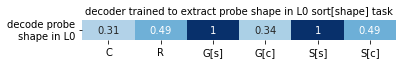

In [ ]:
# decoding transfer

sqtype = 'probe'
layer = 'L0'
task = 'sort[shape]'
feature = 'shape'
transfer_sqtype = 'probe'
transfer_layer = 'L0'
transfer_feature = 'shape'

transfer_accs = acc_df[(acc_df['source_probe_target']==sqtype)&(acc_df['layer']==layer) \
                      &(acc_df['task']==task)&(acc_df['feature']==feature)] \
                      .filter(regex='transfer-acc-%s-%s.*-%s'%(transfer_sqtype, transfer_layer, transfer_feature))

fig, ax = plt.subplots(1, 1, figsize=[5.7,1], sharex=True)
ax.set_title('decoder trained to extract %s %s in %s %s task'%(sqtype, feature, layer, task), fontdict={'fontsize': 10})
im = seaborn.heatmap(ax=ax, data=transfer_accs.values, vmin=0, vmax=1, annot=True, cmap='Blues', cbar=False)
ax.set_xticklabels(['C', 'R', 'G[s]', 'G[c]', 'S[s]', 'S[c]'])
ax.set_yticklabels(['decode %s\n%s in %s'%(transfer_sqtype, transfer_feature, transfer_layer)], rotation=0)
fig.tight_layout()

# fig.savefig('../figure/v1/%s/decoding/%s-%s-%s-%s_transfer_%s-%s-%s.pdf'%(runid, sqtype, layer, task, feature, transfer_sqtype, transfer_layer, transfer_feature))

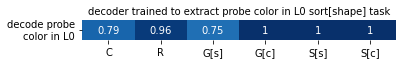

In [ ]:
# decoding transfer

sqtype = 'probe'
layer = 'L0'
task = 'sort[shape]'
feature = 'color'
transfer_sqtype = 'probe'
transfer_layer = 'L0'
transfer_feature = 'color'

transfer_accs = acc_df[(acc_df['source_probe_target']==sqtype)&(acc_df['layer']==layer) \
                      &(acc_df['task']==task)&(acc_df['feature']==feature)] \
                      .filter(regex='transfer-acc-%s-%s.*-%s'%(transfer_sqtype, transfer_layer, transfer_feature))

fig, ax = plt.subplots(1, 1, figsize=[5.7,1], sharex=True)
ax.set_title('decoder trained to extract %s %s in %s %s task'%(sqtype, feature, layer, task), fontdict={'fontsize': 10})
im = seaborn.heatmap(ax=ax, data=transfer_accs.values, vmin=0, vmax=1, annot=True, cmap='Blues', cbar=False)
ax.set_xticklabels(['C', 'R', 'G[s]', 'G[c]', 'S[s]', 'S[c]'])
ax.set_yticklabels(['decode %s\n%s in %s'%(transfer_sqtype, transfer_feature, transfer_layer)], rotation=0)
fig.tight_layout()